<h1><center>DIGITAL EPIDEMIOLOGY 2018</center></h1>
<h2><center>Homework 1</center></h2>

## Team:

** Alikana Pavan Kumar (1826777)**

** Dudekula Dastagiri (1826239)**

** Gunturi Vamsi Krishna Varma (1794653)**

# Table of Contents
[Introduction](#0)

[Data Collection](#1)
     
[Data Correlation](#2)
   
[Regression Analysis](#3)
    
[Conclusion](#4)

[Summary](#5)

## Introduction <a name="0"></a>

 - The goal of this assignment is to estimate, in near-real time, the level of **influenza-like illness (ILI)** in Italy by monitoring the rate of particular **Wikipedia** article views on a daily basis. We calculated the number of times certain influenza- or health-related Wikipedia articles were accessed each day between October 2015 and April 2018 and compared these data to official ILI activity levels provided by Influnet (*Rete Italiana Sorveglianza Influenza*).

- We have created a method of estimating current ILI activity in Italy by gathering information on the number of times particular Wikipedia articles have been viewed. Wikipedia is a massive, user-regulated, online encyclopedia.


- **The purpose of this assignment is to develop a statistical model to provide near real-time estimates of ILI activity in Italy using freely available data gathered from the online encyclopedia, Wikipedia.**


**Our Folder structure**

--- Python Notebook

--- influnet - [contains the PDF files from influnet survivelence system. We are considering the data of 2015-16, 2016-17, 2017-18 for our analysis]

--- wiki - [contains the all the data collected from wikipedia based on the pages that we selected for our analysis]

--- regression_analysis.csv - this is the dataset for our regression analysis

In [148]:
# Importing required librares

import os
import datetime
import pandas as pd
import numpy as np

# Packages for data collection and visulaisation
import pageviewapi
import tabula
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import requests, random, time

# Packages for doing statistical analysis
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

# Data Collection <a name="1"></a>

In [72]:
# Load the required utility functions

#%%writefile code/utilities.py

def toCapitalize(str):
    str = str[:1].upper() + str[1:]
    return str

#This function retrieves the views of the Wikipedia page <pagename> from the pageview API 
def retrieve_pageviews(pagename):  
    # We are considering below time period as per the data that we have from Influnet survivelence system,
    # Which is for better correlation
    
    from_ = "20151012"
    to_ = "20180429"
    wiki_page =  pd.DataFrame(index = range((datetime.datetime.strptime(to_, "%Y%m%d").date() - datetime.datetime.strptime(from_, "%Y%m%d").date()).days), columns=["date", "views"])
    try:
        cont = 0
        for v in pageviewapi.per_article('it.wikipedia', pagename, from_, to_, access='all-access', agent='all-agents', granularity='daily')["items"]:
            wiki_page.loc[cont] = [datetime.datetime.strptime(v["timestamp"][:-2], "%Y%m%d"), v["views"]]
            cont+=1
        wiki_page = wiki_page.set_index("date").resample('W').sum().reset_index()
        wiki_page["week"] = 0
        wiki_page["year"] = 0
        for i in range(len(wiki_page)):
            wiki_page.loc[i,"week"] = wiki_page.loc[i,"date"].isocalendar()[1]
            wiki_page.loc[i,"year"] = wiki_page.loc[i,"date"].isocalendar()[0]
        return(wiki_page)
    except pageviewapi.client.ZeroOrDataNotLoadedException:
        print("Page Not Found!!!" + pagename + "!!!")
    return []

### Fetch Influenza page views data from wikipedia

In [73]:
#get Influenza data from wikipedia page
influenza = retrieve_pageviews("Influenza")

#Save to local file
influenza.to_csv("wiki/influenza.csv")

### Fetch Influnet data from pdf files in 'influnet' folder and consolidate the information in to a single csv file

In [27]:
# Run only for the FIRST TIME
mdf = pd.DataFrame()
import tabula
# iterating over list of least recent 3 years
for file_name in ['2015-2016', '2016-2017', '2017-2018']:

    # Read pdf into DataFrame
    df = tabula.read_pdf("influnet/" + file_name + ".pdf", options="--pages 2")
    df1 = pd.DataFrame()
    df1 = df.iloc[2:,0:5]
    mdf = mdf.append(df1)
    
mdf = mdf.reset_index(drop=True)

mdf['Week'] = 0
mdf['Year'] = 0

for i in range(len(mdf)):
    y_w = mdf.loc[i,"Unnamed: 0"].split('-')
    mdf.loc[i,"Week"] = y_w[1]
    mdf.loc[i,"Year"] = y_w[0]
    
#Save to local file
mdf.to_csv("influnet/influnet_total.csv")

In [74]:
# Loading Influenza and Influnet data into local dataframes
wiki_df = pd.read_csv("wiki/influenza.csv") 
influnet_df = pd.read_csv("influnet/influnet_total.csv", sep=';') #influnet

### Combining the data from Influenza and Influent survelence system in to one CSV file for easy correlation

In [75]:
#Adding Influenza data to main Dataframe(influnet_total)
influnet_df["Views"] = 0
print(len(influnet_df))
for i in range(len(influnet_df)):
    influnet_df.loc[i,"Views"] = int(wiki_df.loc[(wiki_df["year"]==influnet_df.loc[i, "Year"]) & (wiki_df["week"]==influnet_df.loc[i, "Week"])]["views"].values[0])
    #Replacing , with . in total incidence percentage for further calculation
    influnet_df.loc[i,"Percentage"] = influnet_df.loc[i,"Percentage"].replace(",", ".")


84


In [77]:
#sample data how we are loading into one consolidated dataframe
print(influnet_df.head())

   Unnamed: 0 WeekOfYear Percentage  Week  Year  Views
0           0    2015-42       0.40    42  2015   1464
1           1    2015-43       0.50    43  2015   1406
2           2    2015-44       0.68    44  2015   1278
3           3    2015-45       0.76    45  2015   1389
4           4    2015-46       0.88    46  2015   1349


**Note:** Above is the column format of the consolidated data set, here **Views** are the views of Influenza article and **Percentage** is the incidence total from influnet survivelence system. The values in the **Percentage** column are our ground truth and we use these values as a dependant/output variable for the regression analysis

# Data Corelation <a name="2"></a>

# PART 1

## 1.1 - Influenza page view time series from 2015 to 2018

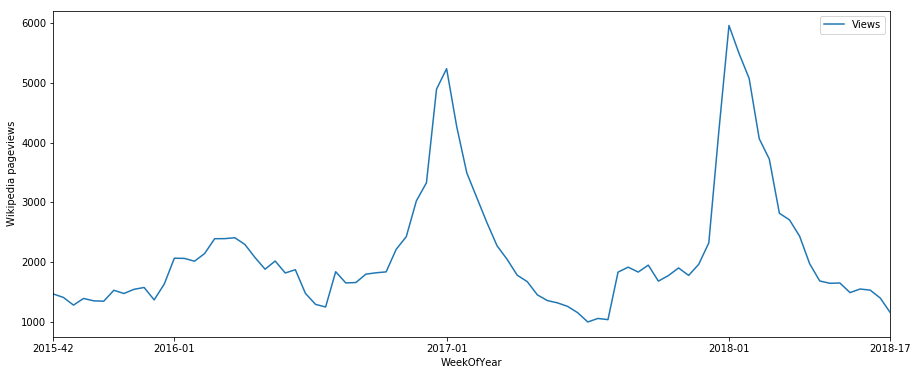

In [78]:
#Plot the Data
influnet_df.plot(x='WeekOfYear', y='Views', figsize = (15,6))
x_pos = [0]
for x in range(len(influnet_df)):
    if influnet_df.loc[x, "Week"] == 1:
        x_pos.append(x)
x_pos.append(len(influnet_df)-1)
plt.xticks(x_pos,influnet_df.loc[x_pos,"WeekOfYear"].values)
plt.ylabel('Wikipedia pageviews')
plt.show()

## 1.2 Influenza and Influnet time series from 2015 to 2018

We tried to compare values of Influenza page views(on wikipedia) and Influnet data over the period of 2015 to 2018 by normalizing the page views and percentage based on mean and standard deviation of both the **Views** and **Percentage** columnn values  

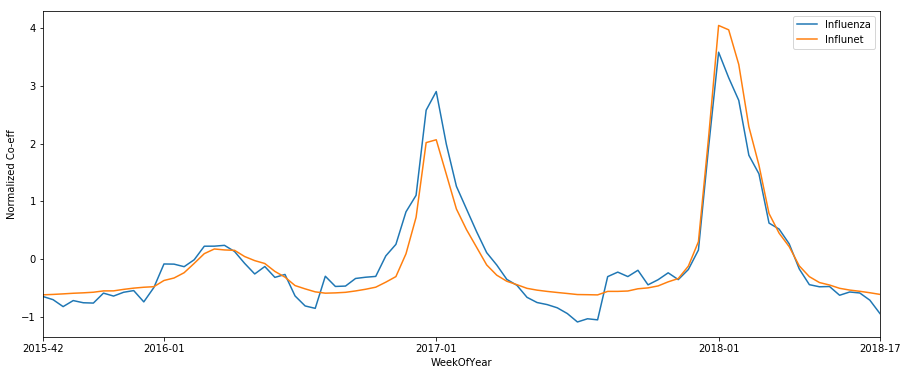

In [79]:
influnet_df["Real"] = 0
for i in range(len(influnet_df)):
    influnet_df.loc[i,"Real"] = influnet_df.loc[i,"Views"] * float(influnet_df.loc[i,"Percentage"])
    
#Normalize the real and actual view data and plot them
influnet_df["Influnet"] = (influnet_df["Real"]-influnet_df["Real"].mean())/influnet_df["Real"].std()
influnet_df["Influenza"] = (influnet_df["Views"]-influnet_df["Views"].mean())/influnet_df["Views"].std()

pear_output = list(pearsonr(influnet_df["Influnet"], influnet_df["Influenza"]))

influnet_df.plot(x='WeekOfYear', y=['Influenza', 'Influnet'], figsize = (15,6))
plt.xticks(x_pos,influnet_df.loc[x_pos,"WeekOfYear"].values)
plt.ylabel('Normalized Co-eff')
plt.show()

As we can see from the graph there is a considerable correlationn between Influenza and Influnet time series for the time period of our consideration so we can proceed with the ground truth of Incidence total from the Influnet dataset. 

The correlation between these 2 data sets is as shown below

In [80]:
influenet_list = list(influnet_df["Influnet"])
influenza_list = list(influnet_df["Influenza"])
pear_output = list(pearsonr(influenet_list, influenza_list))

print(pear_output)

[0.9583575193190425, 2.1394154758163885e-46]


As we can see there is high correlation between Influenza incidence from Influnet data and Influenza page views from Wikipedia. We save the normalised values in our data set for further regression analysis

In [81]:
# Sample view of tatal consolidated dataframe 'influnet_df'
influnet_df.head()

,Unnamed: 0,WeekOfYear,Percentage,Week,Year,Views,Real,Influnet,Influenza
0,0,2015-42,0.40,42,2015,1464,585.60,-0.617685,-0.646921
1,1,2015-43,0.50,43,2015,1406,703.00,-0.610985,-0.701439
2,2,2015-44,0.68,44,2015,1278,869.04,-0.601510,-0.821755
3,3,2015-45,0.76,45,2015,1389,1055.64,-0.590862,-0.717418
4,4,2015-46,0.88,46,2015,1349,1187.12,-0.583359,-0.755017


# PART 2

# 2.1 - Find other Wikipedia pages related to flu whose pageview time series are correlated with the Influnet signal.

In [123]:
# Flu related wikipedia pages for our analysis
wiki_list = ['Influenza','Tosse post-virale','Paracetamolo','Antibiotico','Polmonite',
              'Bronchiolite','Orthomyxoviridae','Febbre','Rinite medicamentosa','Antivirale',
              'Virus respiratorio sinciziale umano','Ibuprofene','Antivirali',
              'Virus parainfluenzali umani','Tonsillite','Laringospasmo','Faringite',
              'Starnuto','Pandemia','Virus (biologia)', 'Fitoterapia', 'Asma', 'Convulsioni_febbrili', 'Inverno', 'Virus_(biologia)', 'sinusite', 'Malattia',
             'Mercurio_(elemento_chimico)', 'Difterite', 'Omeopatia', 'antinfluenzale', 'Faringite', 'Vaccino', 'Vomito',
             'asma', 'Influenza aviaria', 'bronchite', 'influenzale', 'Febbre', "Succo_d'arancia", 'Ippocrate', 'Antipiretico',
             'Influenzavirus A', 'Vaccino_antinfluenzale', 'starnuto', 'Silicosi', 'Tosse', 'Bronchite',
             'Influenza e fortuna del pensiero di Nietzsche', 'Tachipirina', 'Feniramina', 'Clima_italiano',
             'Paracetamolo', 'Epatopatia', 'asiatica', 'Raffreddore_comune', 'Lacrima', 'Mononucleosi infettiva',
             'Rinorrea', 'Mialgia', 'Arnica', 'Ipotermia', 'Cefalea', 'Rinite', "Virus dell'influenza A sottotipo H1N1",
             'Naturopatia', 'Bronchiolite', 'Raffreddore', 'Antibiotico', 'Cianosi', 'Influenzavirus A sottotipo H1N1',
             'Vaccino influenza stagionale', 'Amantadina', 'faringite', 'Influenza spagnola', 'Morbillo',
             'Acido_acetilsalicilico', 'Virale', 'antibiotico', 'Antracosi', 'Aerosol', 'Siderosi', 'Zanamivir',
             'Principio_attivo', 'Influenzavirus_A', 'Flurbiprofene', 'Antivirale', 'Ketoprofene', 'Aspirina',
             'Contagio', 'Propoli', 'acido', 'paracetamolo', 'polmonite', 'Enfisema', 'Pagina_principale', 'Influenza',
             'Faringite_streptococcica', 'vomito', 'Diarrea', 'Bacteria', 'virus', 'tosse', 'Artralgia', 'Tonsillite',
             'Oseltamivir', 'Orthomyxoviridae', 'vaccino', 'Vaccino antinfluenzale', 'Pandemia', 'Bryonia_dioica',
             'Starnuti', 'Ibuprofene', 'Polmonite', 'Amoxicillina', 'febbre', 'Miele', 'Mal_di_testa']

wiki_list = list(set([x.lower() for x in wiki_list]))


In [124]:
# ONLY FOR THE FIRST TIME
# dowloading all pages data from wikipedia 
wiki_data_list = []
for page in wiki_list:
    pageData = retrieve_pageviews(page)
    if(len(pageData) > 50):
        wiki_data_list.append(page)
        pageData.to_csv("wiki/" + page + ".csv")


Page Not Found!!!siderosi!!!
Page Not Found!!!antivirali!!!
Page Not Found!!!antipiretico!!!
Page Not Found!!!virus respiratorio sinciziale umano!!!
Page Not Found!!!flurbiprofene!!!
Page Not Found!!!feniramina!!!
Page Not Found!!!mononucleosi infettiva!!!
Page Not Found!!!influenzavirus a sottotipo h1n1!!!
Page Not Found!!!antinfluenzale!!!
Page Not Found!!!influenzavirus a!!!
Page Not Found!!!vaccino influenza stagionale!!!
Page Not Found!!!laringospasmo!!!
Page Not Found!!!oseltamivir!!!
Page Not Found!!!zanamivir!!!
Page Not Found!!!mal_di_testa!!!
Page Not Found!!!antracosi!!!
Page Not Found!!!contagio!!!
Page Not Found!!!clima_italiano!!!
Page Not Found!!!rinite medicamentosa!!!
Page Not Found!!!starnuti!!!
Page Not Found!!!cianosi!!!
Page Not Found!!!influenza e fortuna del pensiero di nietzsche!!!
Page Not Found!!!orthomyxoviridae!!!
Page Not Found!!!virus dell'influenza a sottotipo h1n1!!!
Page Not Found!!!asiatica!!!
Page Not Found!!!principio_attivo!!!
Page Not Found!!!rinit

** Note: Above pages are not found in wikepedia so we remove them from our analysis **

In [125]:
# Removing influenza data since we already have that information in the main data set
wiki_data_list.remove('influenza')

# Finalised related page list for our analysis
print(wiki_data_list)

['sinusite', 'arnica', 'tonsillite', 'influenza spagnola', 'diarrea', 'paracetamolo', 'virus_(biologia)', 'polmonite', 'acido', 'mercurio_(elemento_chimico)', 'malattia', 'epatopatia', 'enfisema', 'morbillo', 'difterite', 'asma', 'bronchite', 'vomito', 'febbre', 'omeopatia', 'vaccino', 'aspirina', 'cefalea', 'pagina_principale', 'raffreddore', 'virus', 'miele', 'inverno', 'tosse', 'virus (biologia)', 'antibiotico']


## Correlating Influenza wikepedia views with other related pages

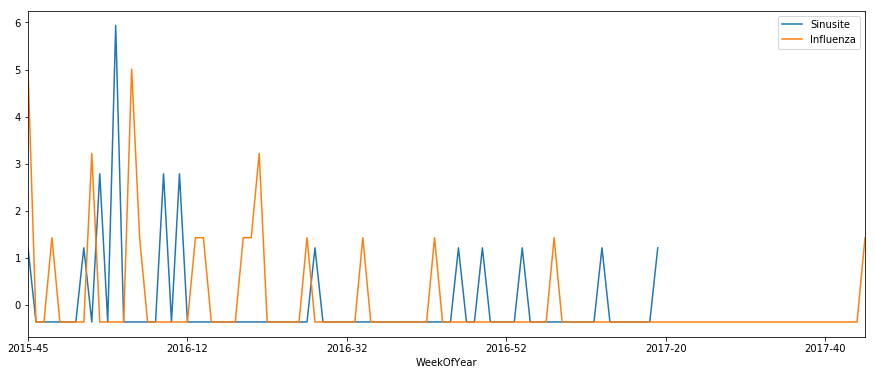

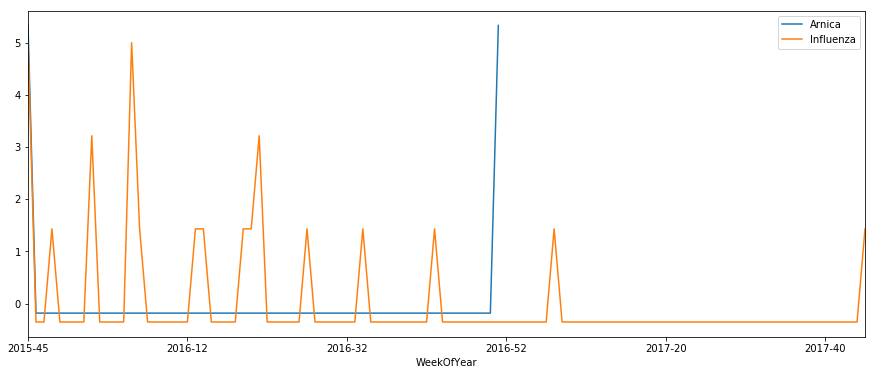

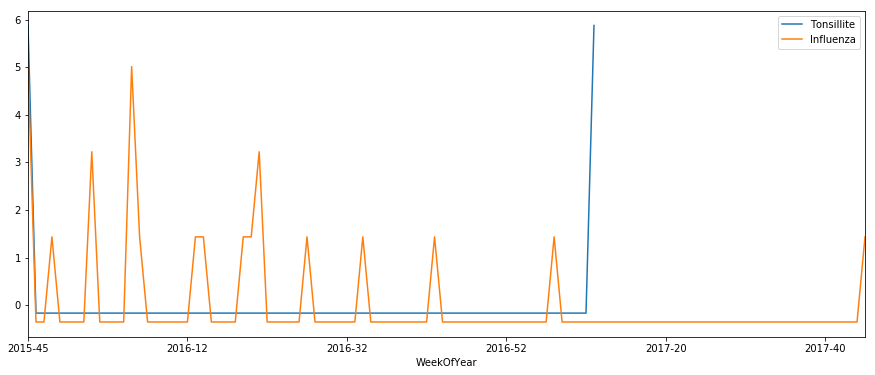

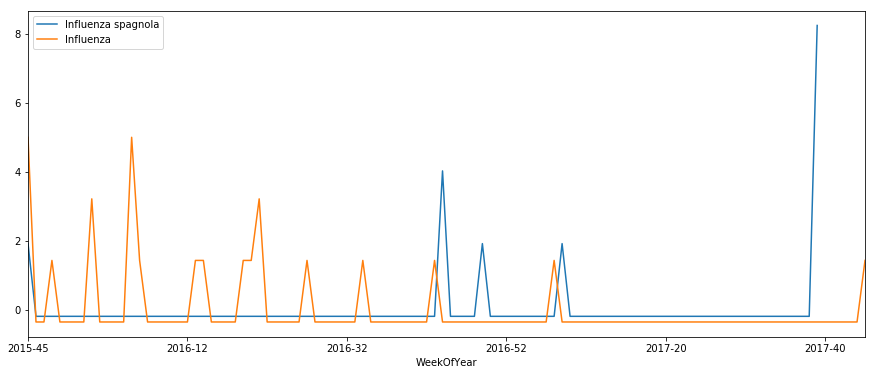

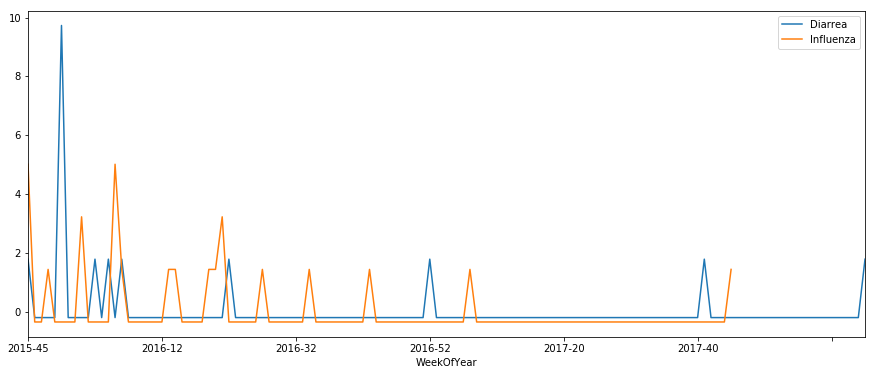

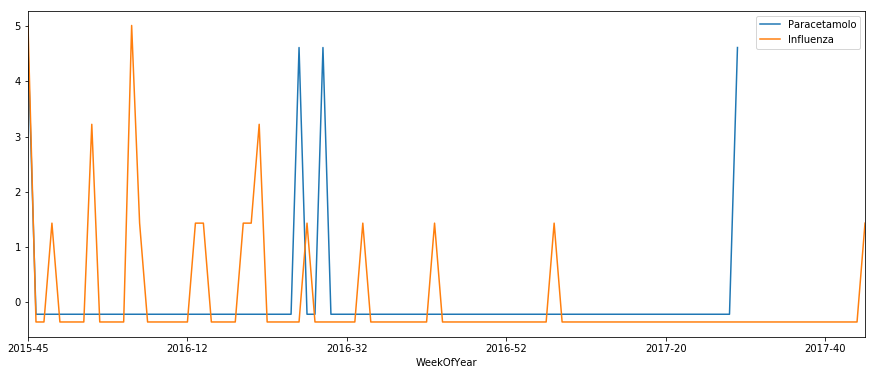

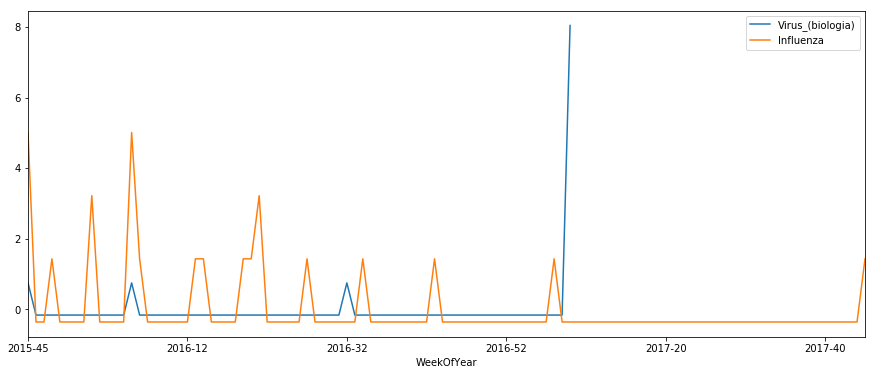

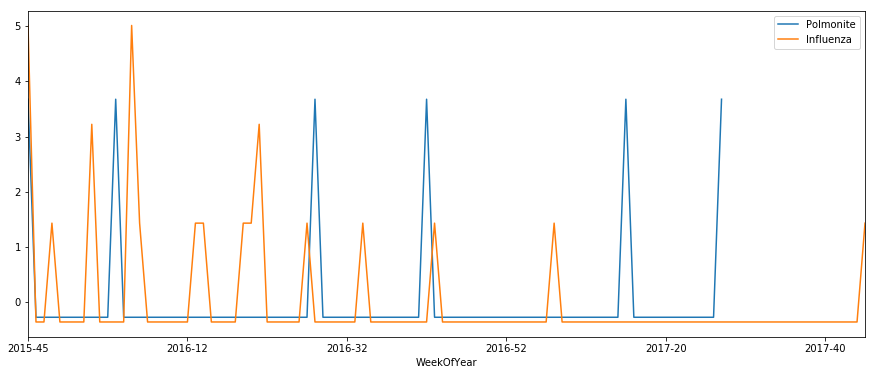

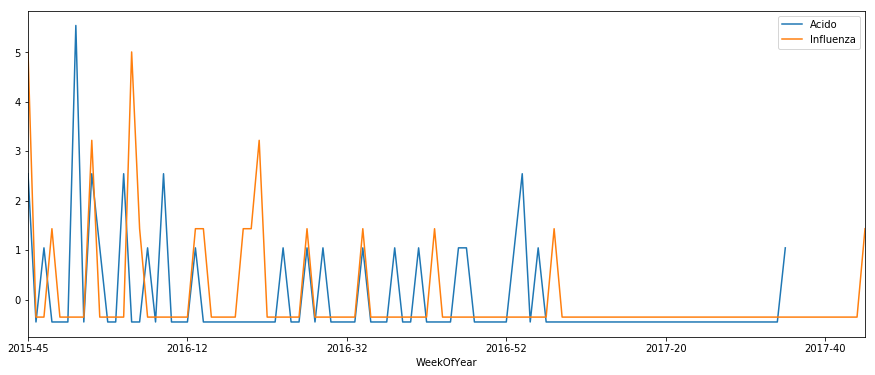

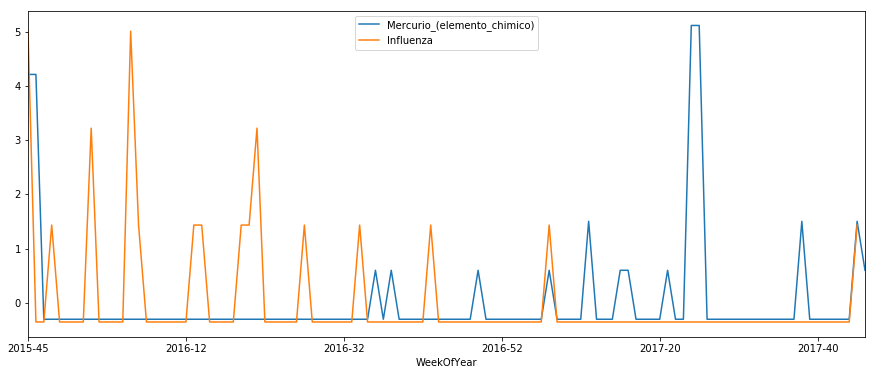

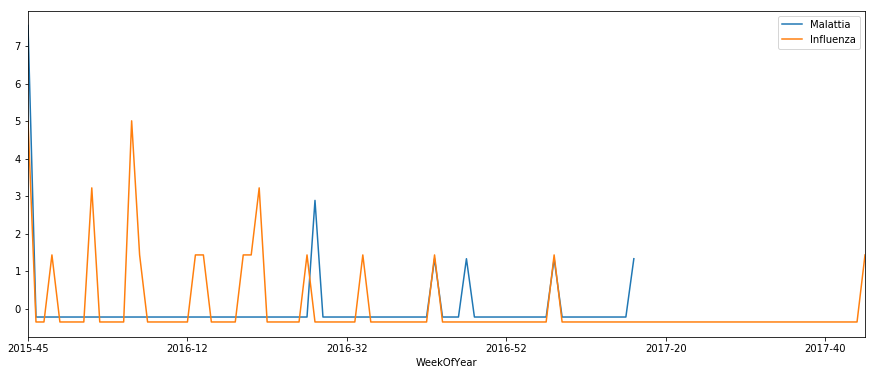

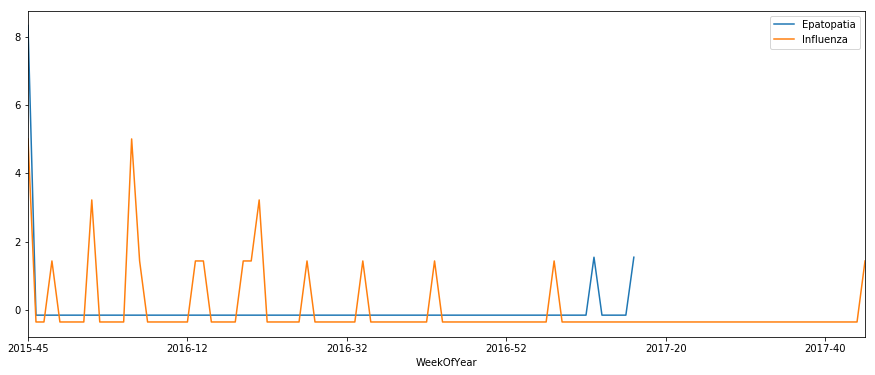

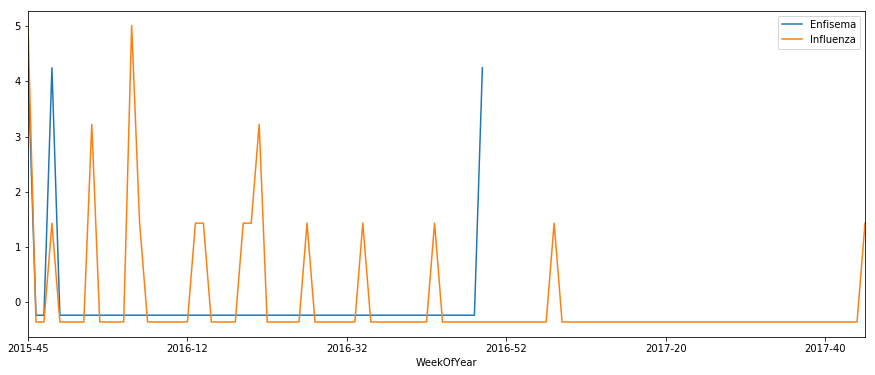

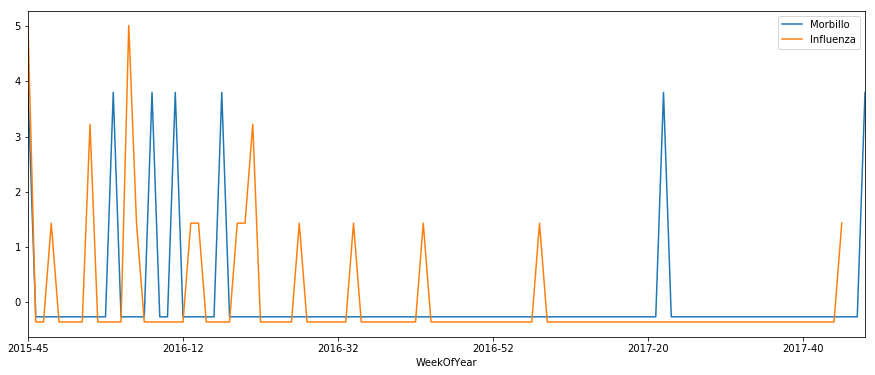

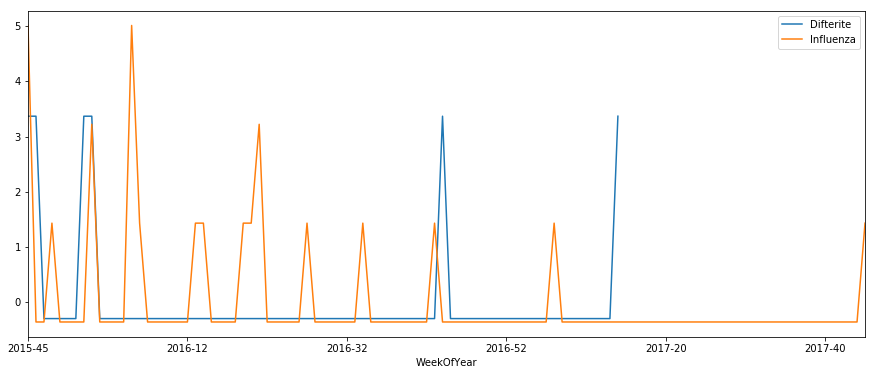

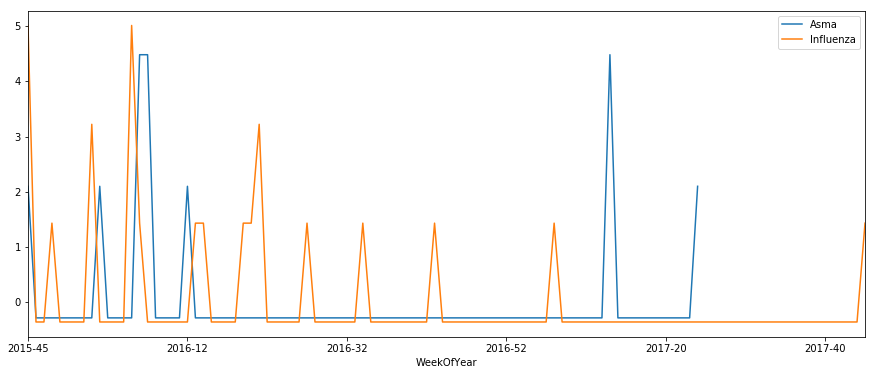

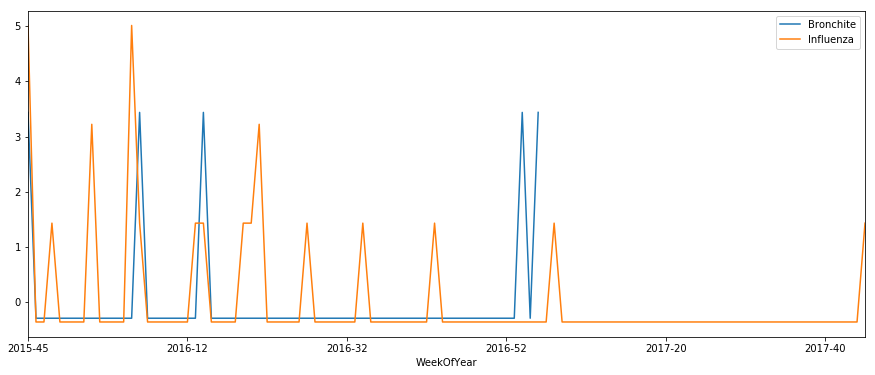

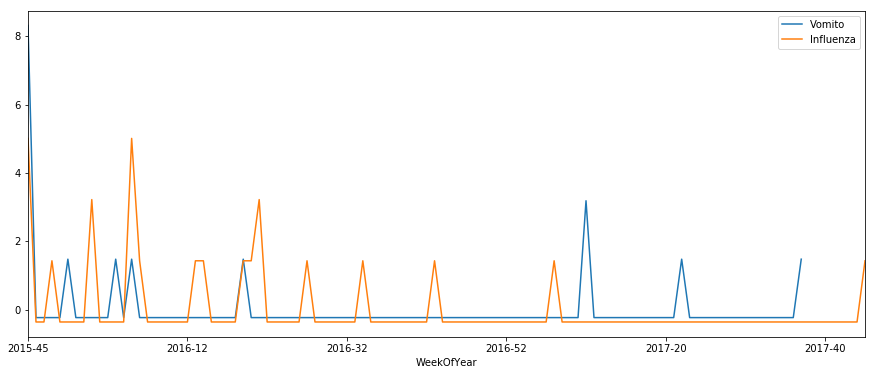

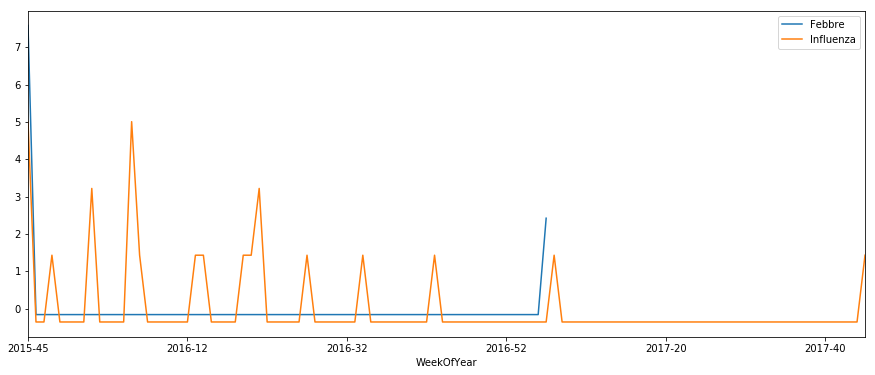

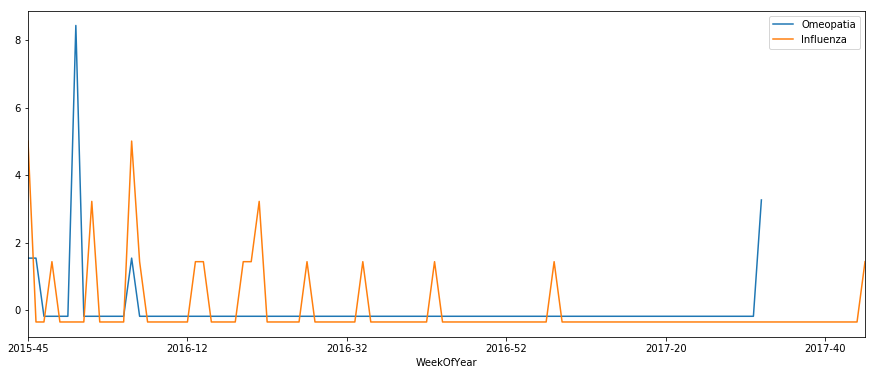

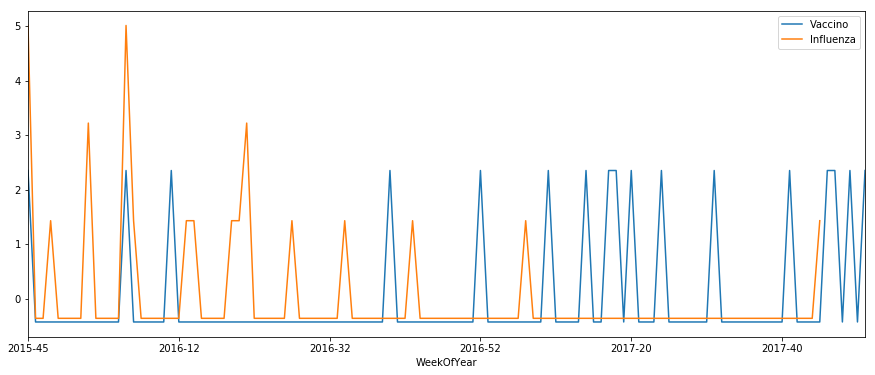

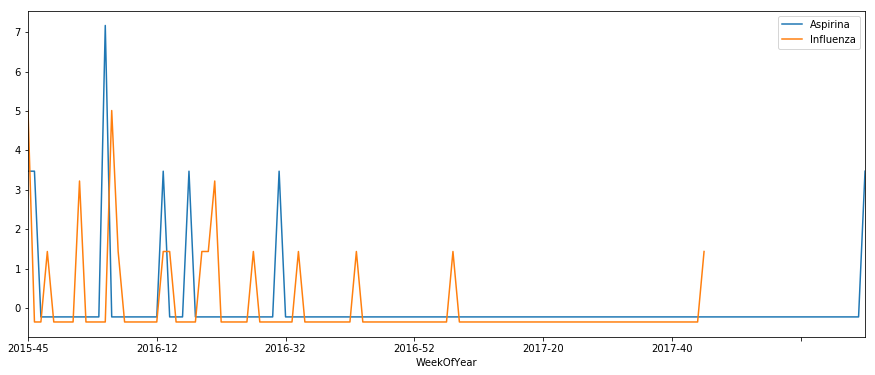

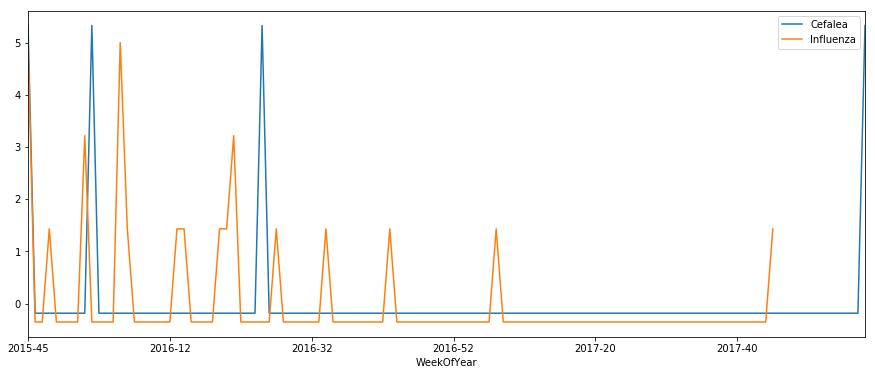

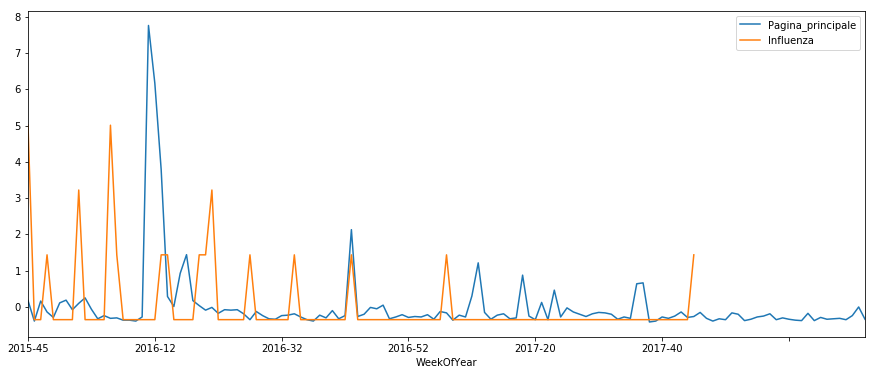

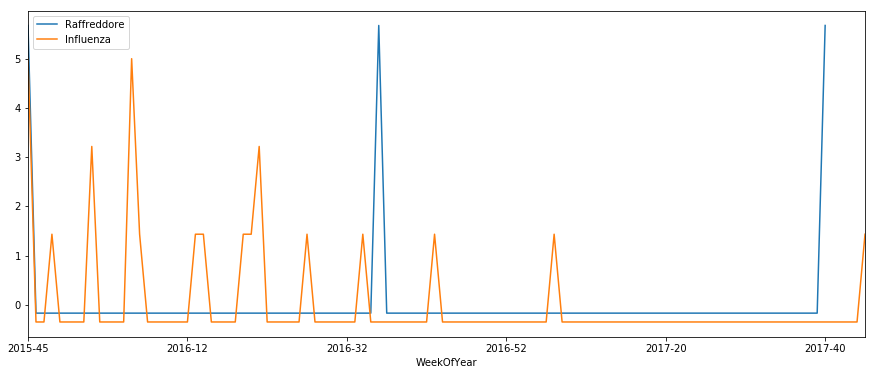

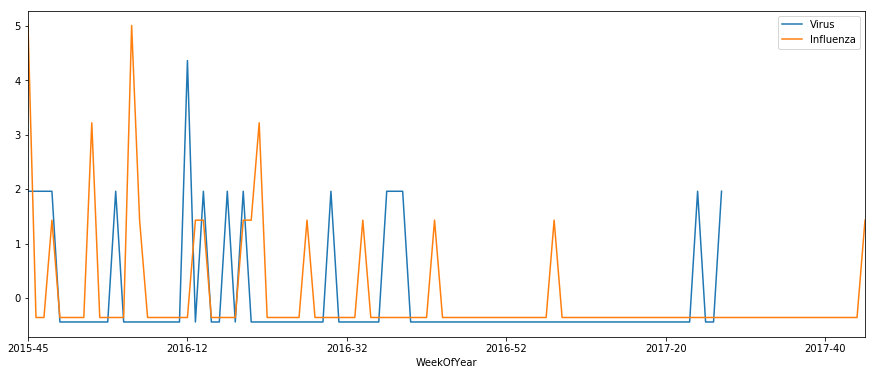

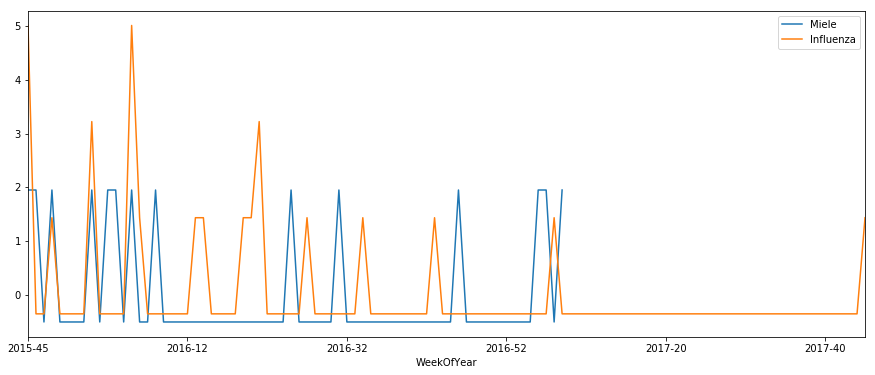

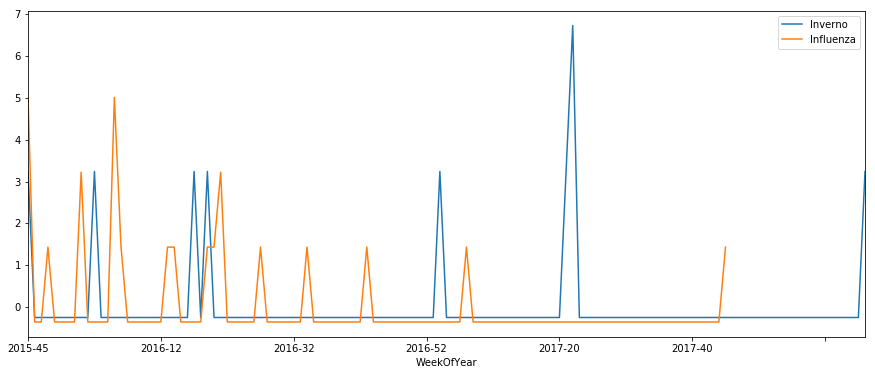

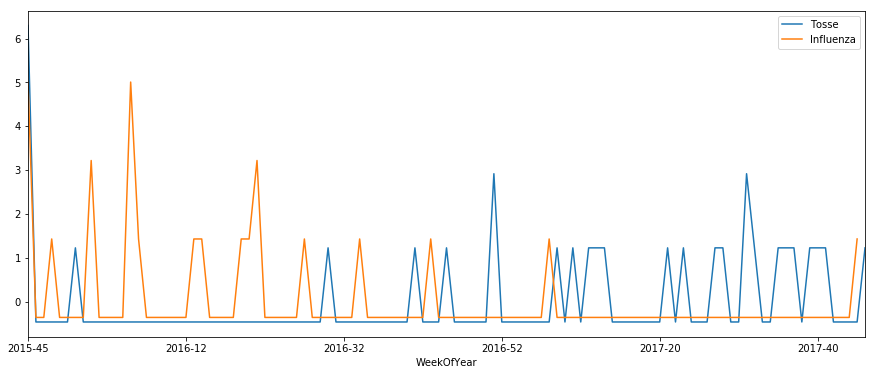

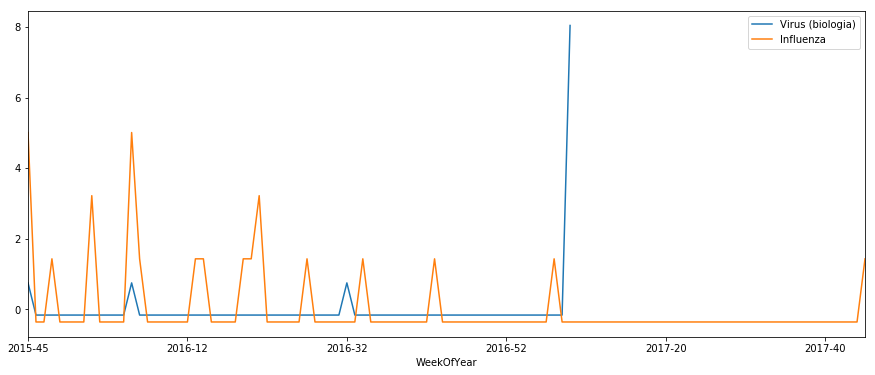

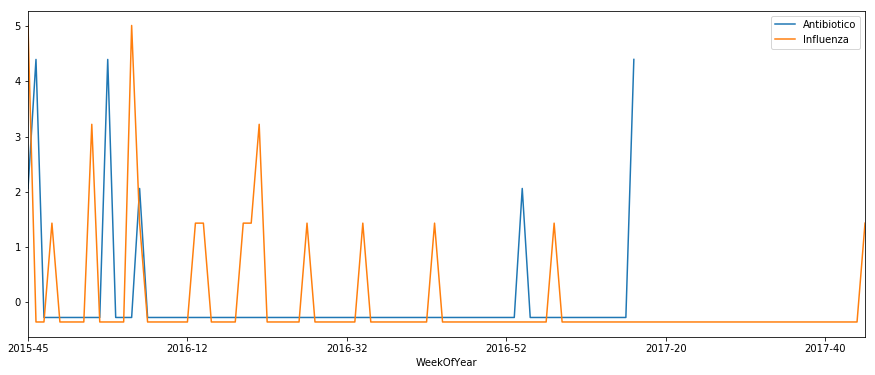

In [126]:
influ_df = pd.read_csv("wiki/influenza.csv")

p_dict = {}
p_corr_list = []
p_p_list = []

influ_df["Influenza"] = 0
#influ_df["Influnet"] = [float(i)/max(influ_df["views"]) for i in influ_df["views"]]
influ_df["Influenza"] = (influ_df["views"]-influ_df["views"].mean())/influ_df["views"].std()

for x in range(len(influ_df)):
    influ_df.loc[x,"WeekOfYear"] = str(influ_df.loc[x,"year"]) + '-' + str(influ_df.loc[x,"week"])
    
i = 0

for page in wiki_data_list:
    page_df = pd.read_csv("wiki/" + page + ".csv")
    
    
    page = toCapitalize(page)
    
    page_df[page] = 0
    #page_df[page] = [float(i)/max(page_df["views"]) for i in page_df["views"]]
    
    page_df[page] = (page_df["views"]-page_df["views"].mean())/page_df["views"].std()
    
    for x in range(len(page_df)):
        page_df.loc[x,"WeekOfYear"] = str(page_df.loc[x,"year"]) + '-' + str(page_df.loc[x,"week"])
    
    merged = pd.merge(influ_df, page_df,left_on=['WeekOfYear'],right_on=['WeekOfYear'],
                      how='left', sort=True).fillna(0)
    
    cmp1 = list(merged['Influenza'])   
    cmp2 = list(merged[page])

    pear_output = list(pearsonr(cmp1, cmp2))
    
    p_dict[page] = cmp2
    
    p_corr_list.append(pear_output[0])
    p_p_list.append(pear_output[1])
    
    px = page_df.plot(x = 'WeekOfYear', y = page, figsize = (15,6))
    
    influ_df.plot(ax = px, x = 'WeekOfYear', y = 'Influenza' )

    #plt.figure(figsize=(10,10))
    plt.show()

#print(p_dict)

## Find the pages which are closely related to Influenza page by Pearson correlation coefficient

In [127]:
## Sort the list based on pearson correlation coefficient value
top_15_p_tuple = sorted(zip(p_corr_list, p_p_list, wiki_data_list), reverse=True)[:10]

p_pages = []
for t in top_15_p_tuple:
    l = list(t)
    p_pages.append(l[2])    
    
print(p_pages)

['miele', 'enfisema', 'bronchite', 'virus', 'paracetamolo', 'sinusite', 'vomito', 'polmonite', 'arnica', 'asma']


 **The above pages are closely related to influenza time series**

## Correlating Influnet data with other related pages

/Users/vamsigunturi/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


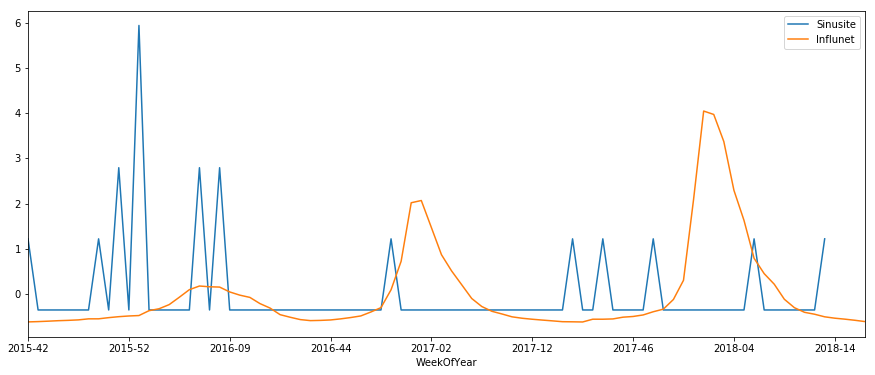

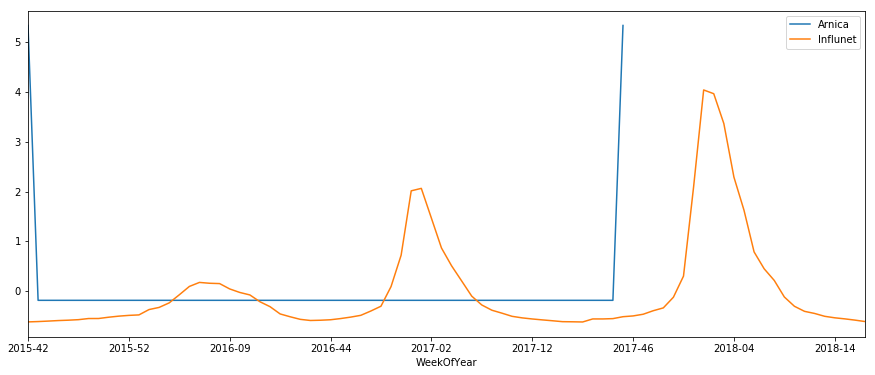

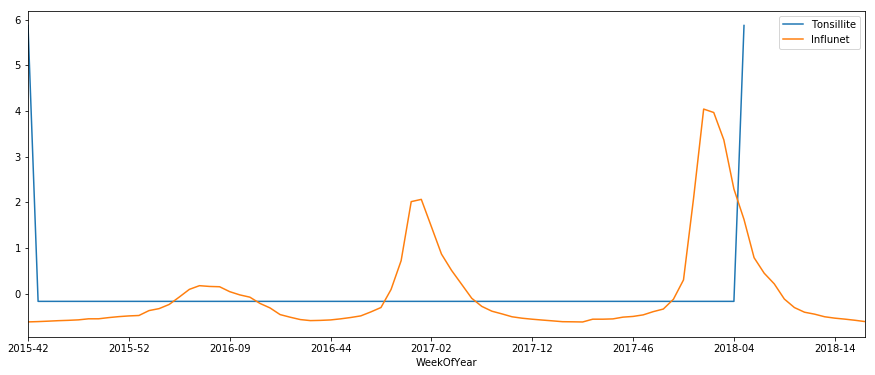

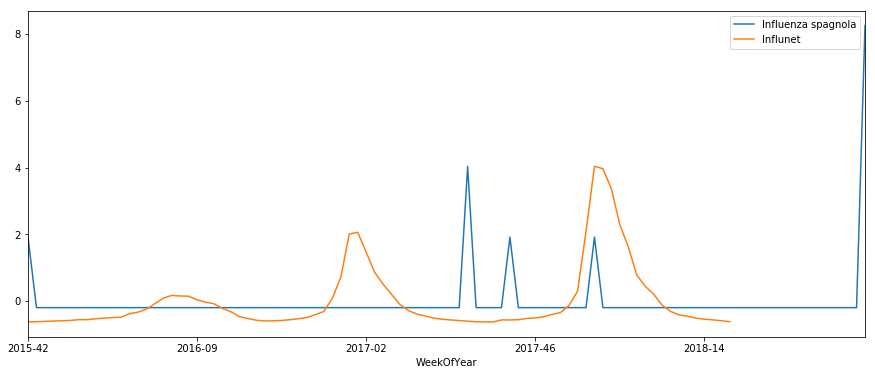

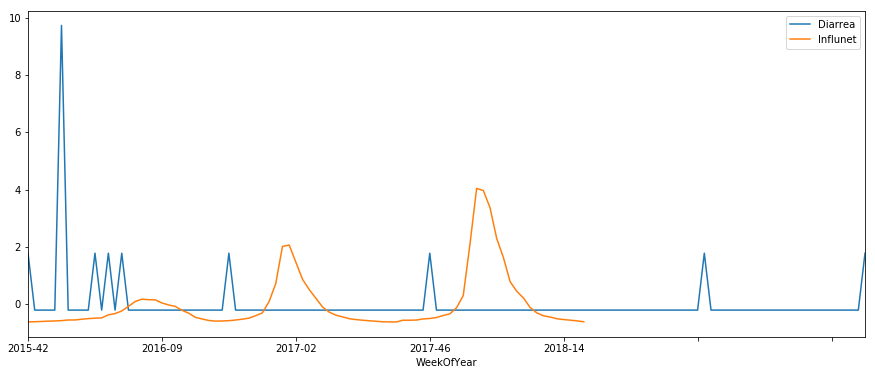

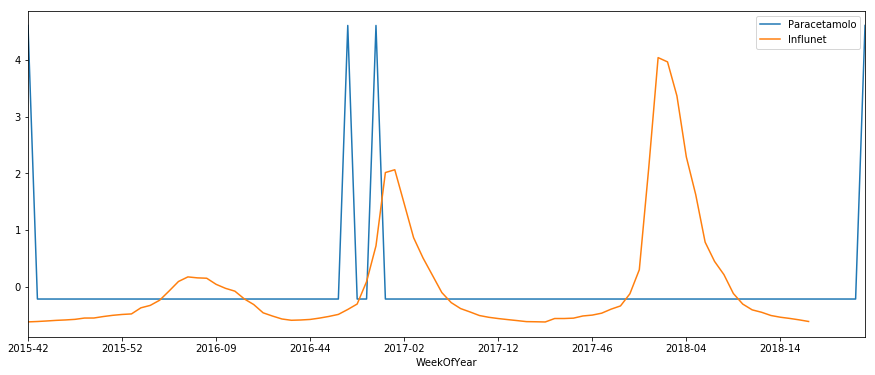

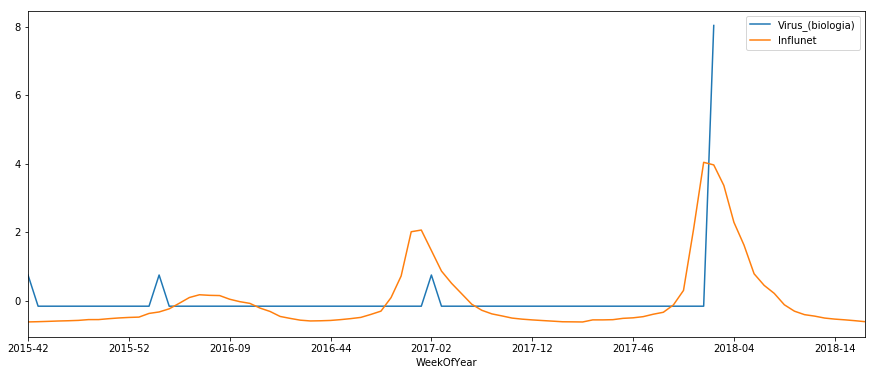

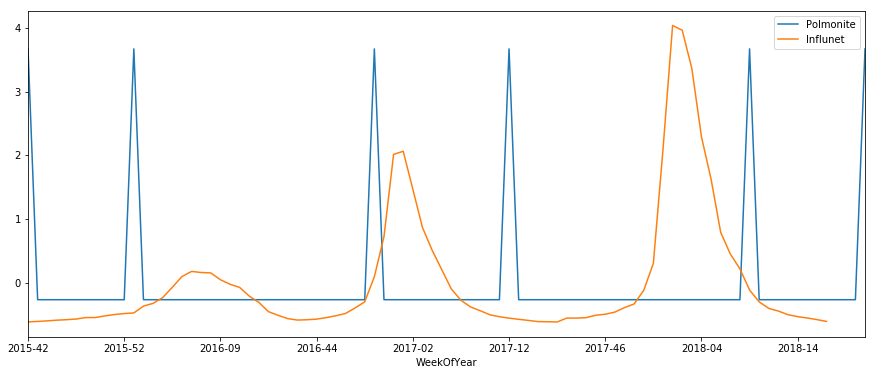

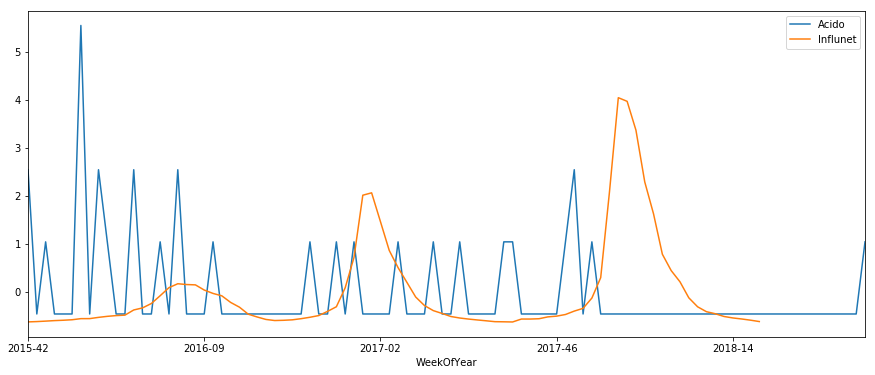

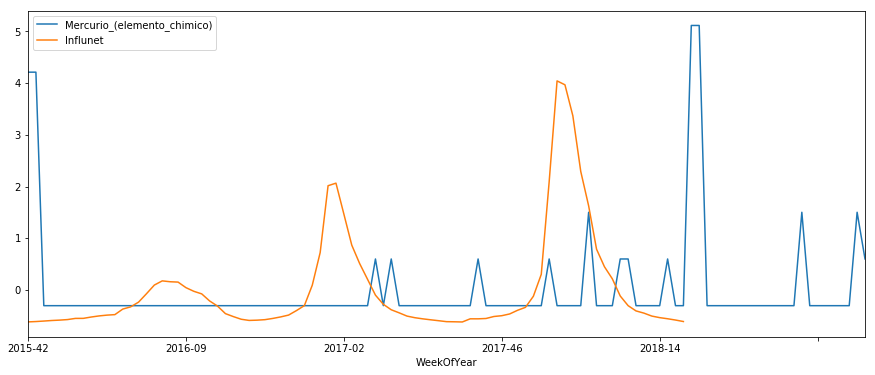

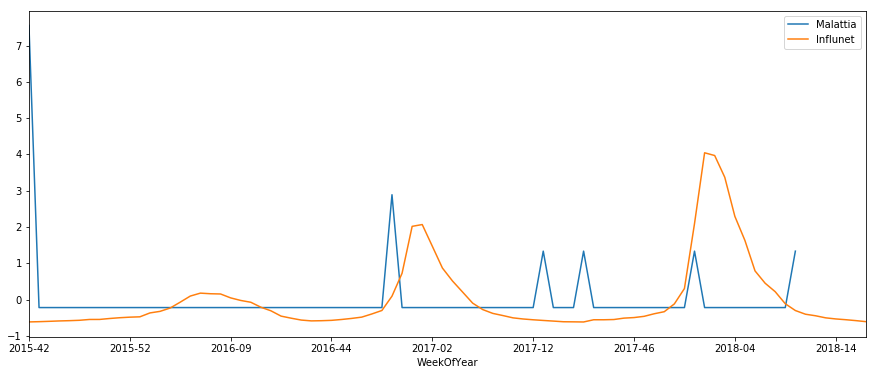

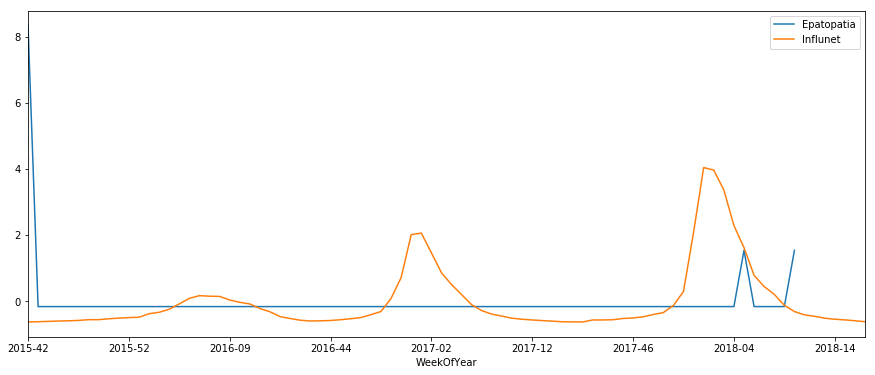

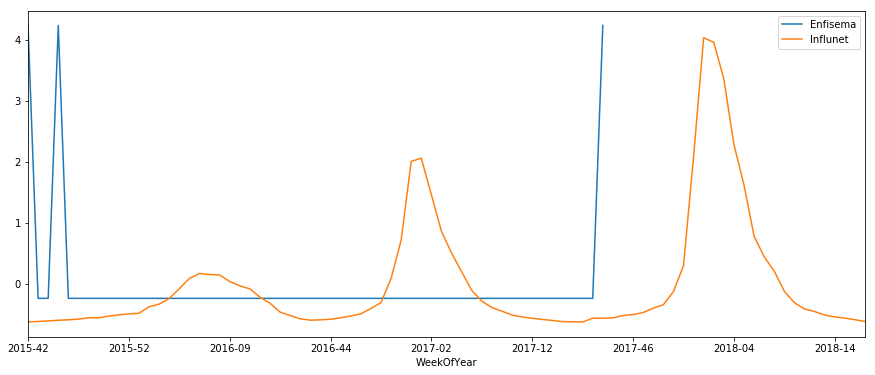

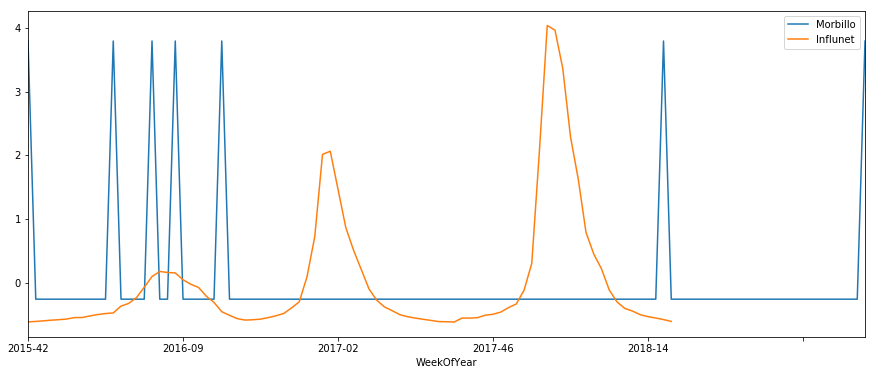

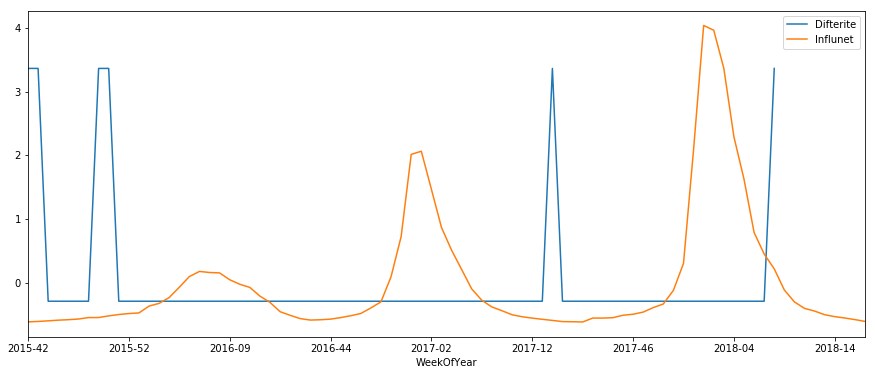

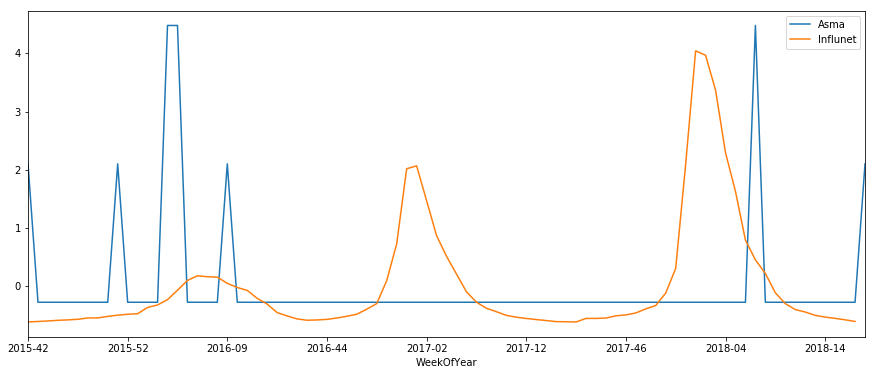

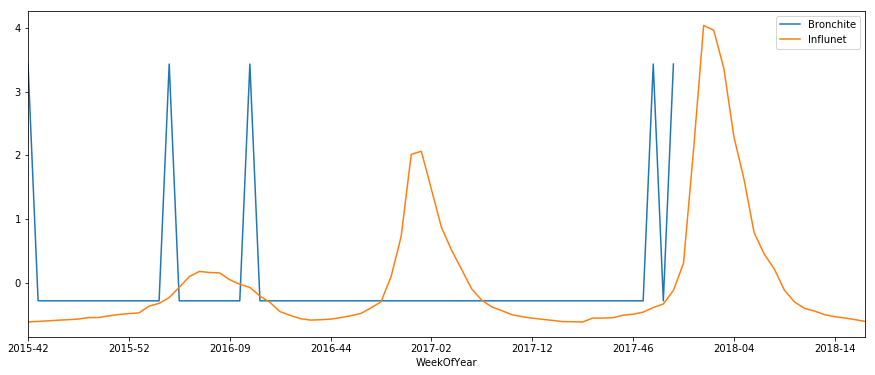

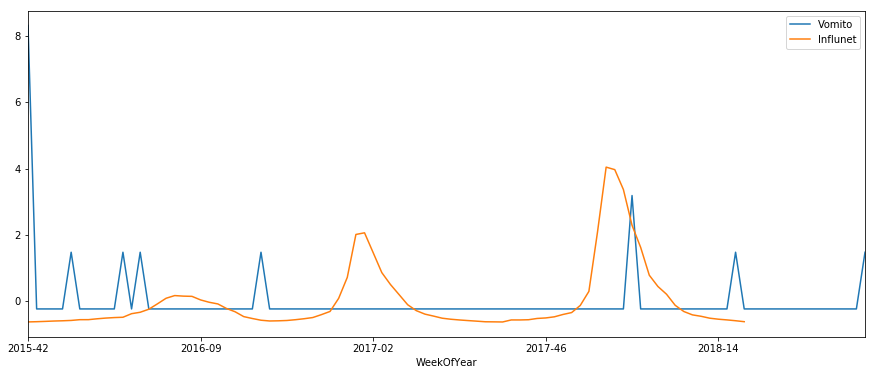

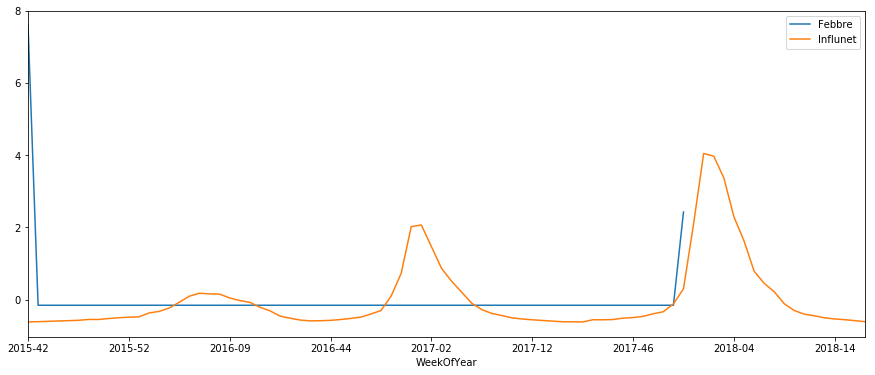

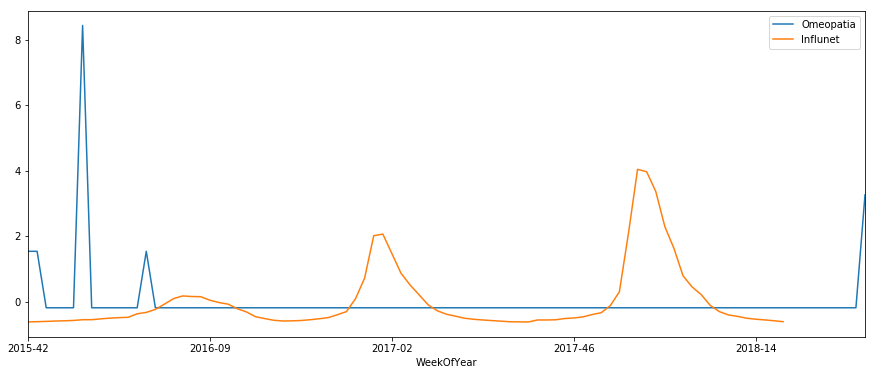

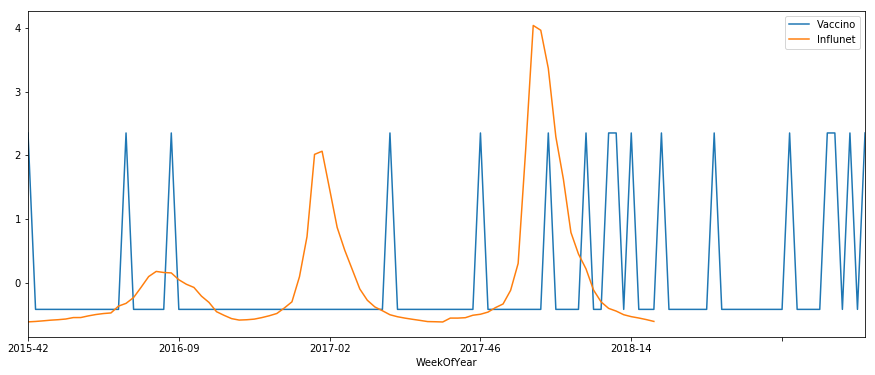

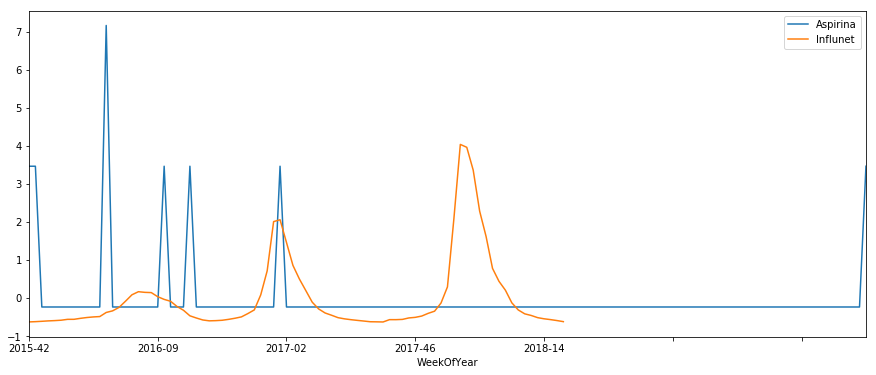

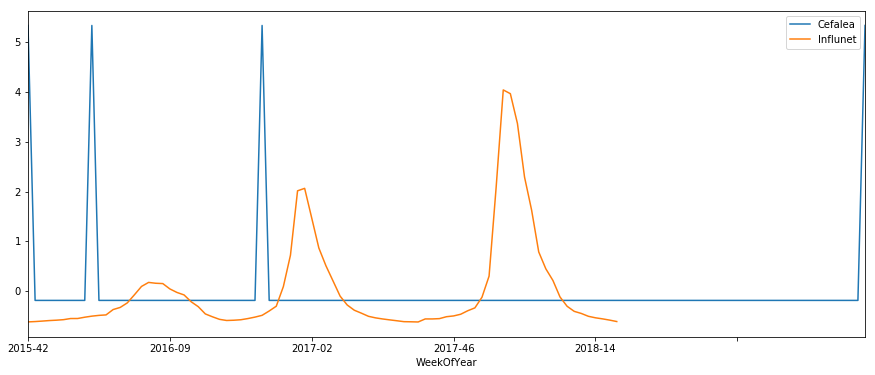

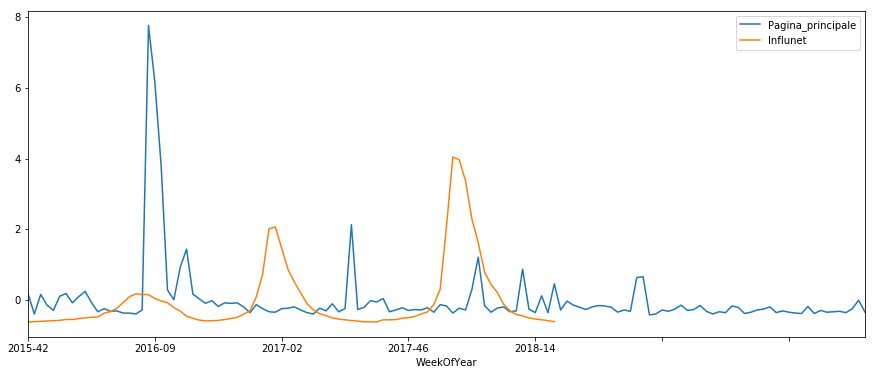

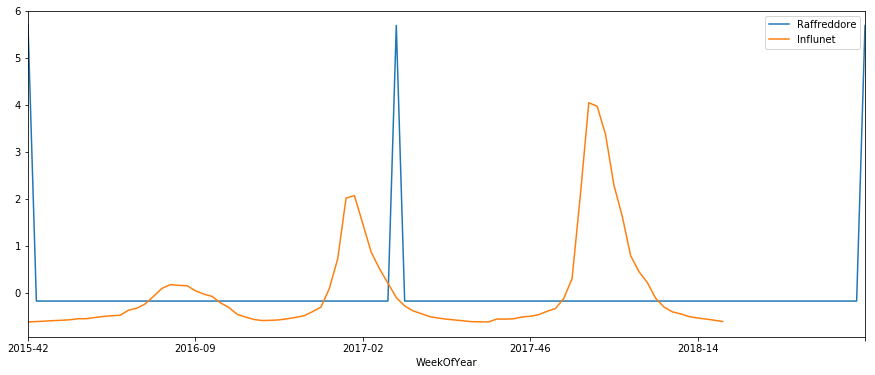

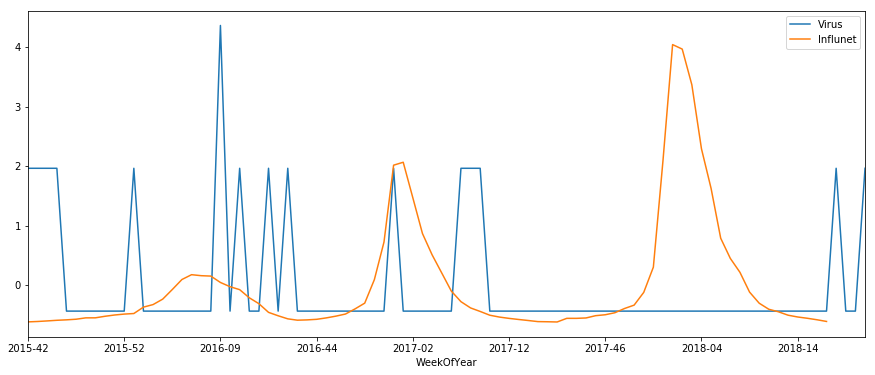

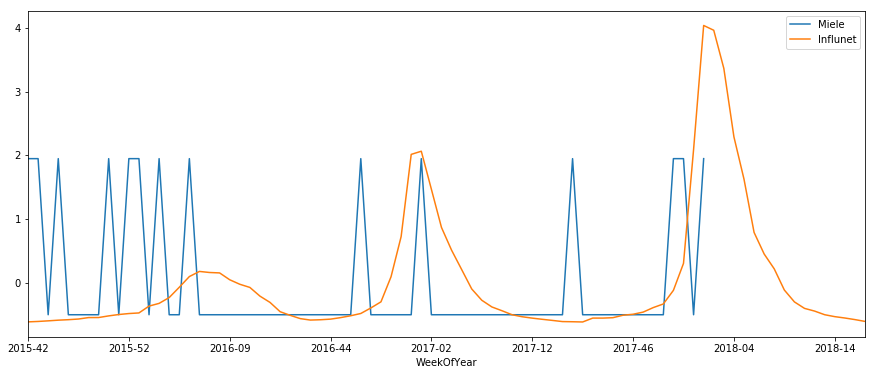

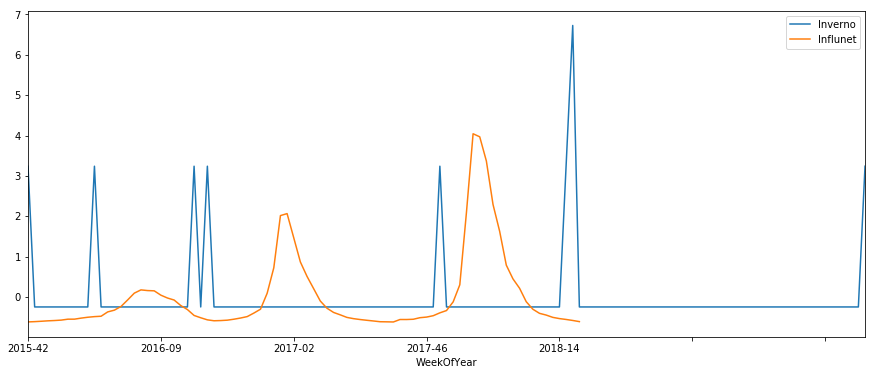

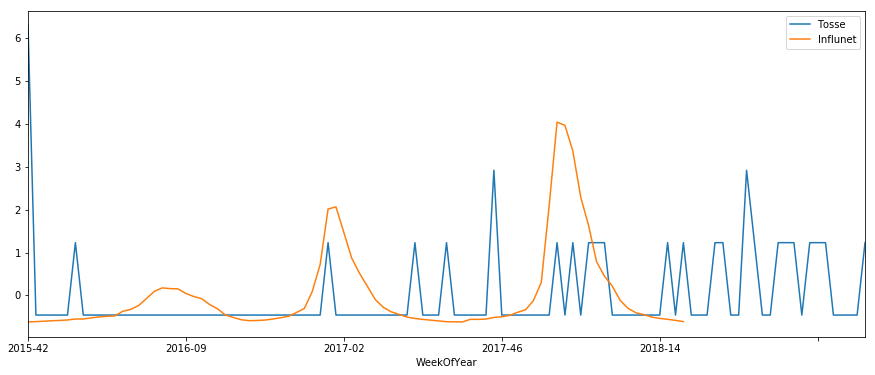

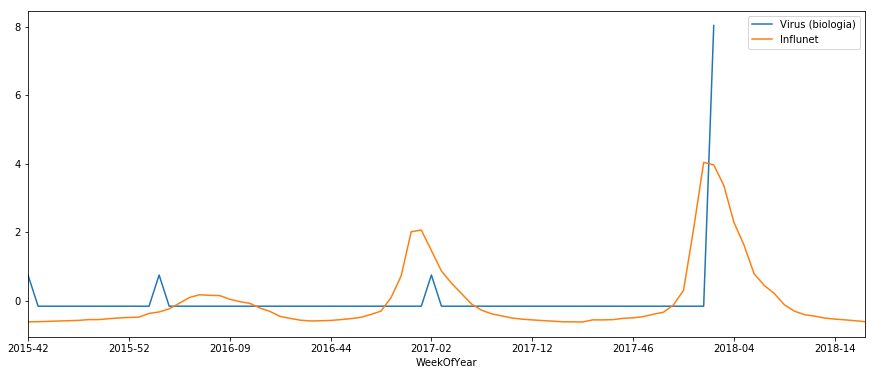

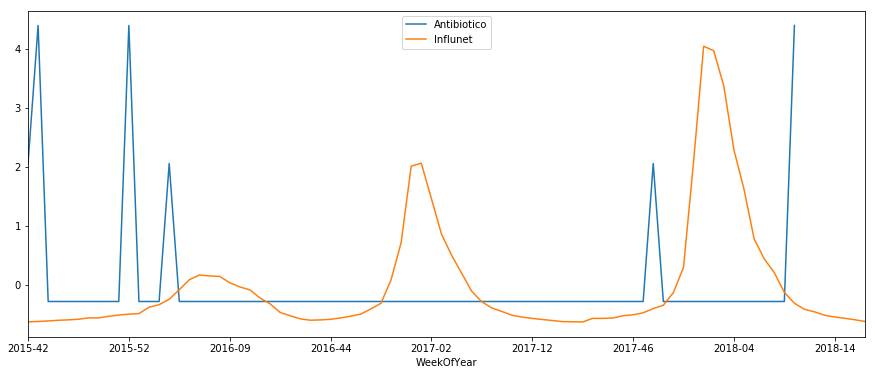

In [128]:
i = 0
i_dict = {}
i_corr_list = []
i_p_list = []

for page in wiki_data_list:
    page_df = pd.read_csv("wiki/" + page + ".csv")
    page = toCapitalize(page)
    page_df[page] = 0
    page_df[page] = (page_df["views"]-page_df["views"].mean())/page_df["views"].std()
    
    page_df['WeekOfYear'] = 0
    for x in range(len(page_df)):
        page_df.loc[x,"WeekOfYear"] = str(page_df.loc[x,"year"]) + '-' + str(page_df.loc[x,"week"])
    
    merged = pd.merge(influnet_df, page_df,left_on=['WeekOfYear'],right_on=['WeekOfYear'],
                      how='left', sort=True).fillna(0)
    
    cmp1 = list(merged['Influnet'])
    cmp2 = list(merged[page])
    pear_output = list(pearsonr(cmp1, cmp2))
    
    i_dict[page] = cmp2
    i_corr_list.append(pear_output[0])
    i_p_list.append(pear_output[1])
    
    px = page_df.plot(x = 'WeekOfYear', y = page, figsize = (15,6))
    influnet_df.plot(ax = px, x = 'WeekOfYear', y = 'Influnet' )

plt.show()


## Find the pages which are closely related to Influnet data by Pearson correlation coefficient

In [129]:
# 5  - 0.16, 0.91
# 10 - 0.18, 0.89
top_10_i_tuple = sorted(zip(i_corr_list, i_p_list, wiki_data_list), reverse=True)[:10]

i_pages = []
for t in top_10_i_tuple:
    l = list(t)
    i_pages.append(l[2])    
    
print(i_pages)

['tonsillite', 'virus_(biologia)', 'virus (biologia)', 'pagina_principale', 'acido', 'tosse', 'bronchite', 'vaccino', 'sinusite', 'antibiotico']


**The above pages are closely related to influnet time series, We use this page list for our regression analysis**

# Regression Analysis <a name="3"></a>

In [130]:
#View data of 'Bronchite' page only
print(i_dict['Bronchite'])

[0.0, 0.0, 3.4373513953892805, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, 3.4373513953892805, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, -0.28644594961577335, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


***Note: For ease of preparing the dataset we are storing each page data in dictionary. Above is the data stored for a particular page***

### Preparing the regression data set

In [131]:
def getCols():
    cols = []
    data_cols = []
    for page in i_pages:
        data_cols.append(toCapitalize(page))
        
    data_cols.append('Influenza')
    cols = data_cols + ['Influnet'] 
    return [cols, data_cols] 

cols_meta = getCols()
r_df_cols = cols_meta[0]

r_df =  pd.DataFrame(columns=r_df_cols)

r_df['Influenza'] = influnet_df['Influenza']
r_df['Influnet'] = influnet_df['Influnet']

for col in cols_meta[1]:
    if col in i_dict.keys():
        r_df[col] = i_dict[col]
        

In [132]:
print(r_df.head()) #Top 10

   Tonsillite  Virus_(biologia)  Virus (biologia)  Pagina_principale  Acido  \
0         0.0               0.0               0.0           0.171309    0.0   
1         0.0               0.0               0.0          -0.393274    0.0   
2         0.0               0.0               0.0           0.158762    0.0   
3         0.0               0.0               0.0          -0.142348    0.0   
4         0.0               0.0               0.0          -0.292904    0.0   

   Tosse  Bronchite   Vaccino  Sinusite  Antibiotico  Influenza  Influnet  
0    0.0   0.000000  0.000000       0.0          0.0  -0.646921 -0.617685  
1    0.0   0.000000  0.000000       0.0          0.0  -0.701439 -0.610985  
2    0.0   3.437351  2.353368       0.0          0.0  -0.821755 -0.601510  
3    0.0  -0.286446 -0.421129       0.0          0.0  -0.717418 -0.590862  
4    0.0  -0.286446 -0.421129       0.0          0.0  -0.755017 -0.583359  


### Above is the dataset structure which we used for regression analysis

In [133]:
# Saving the prepared data set
r_df.to_csv("regression_analysis.csv")

## Visualizing all the correlations between each feature added to the dataset

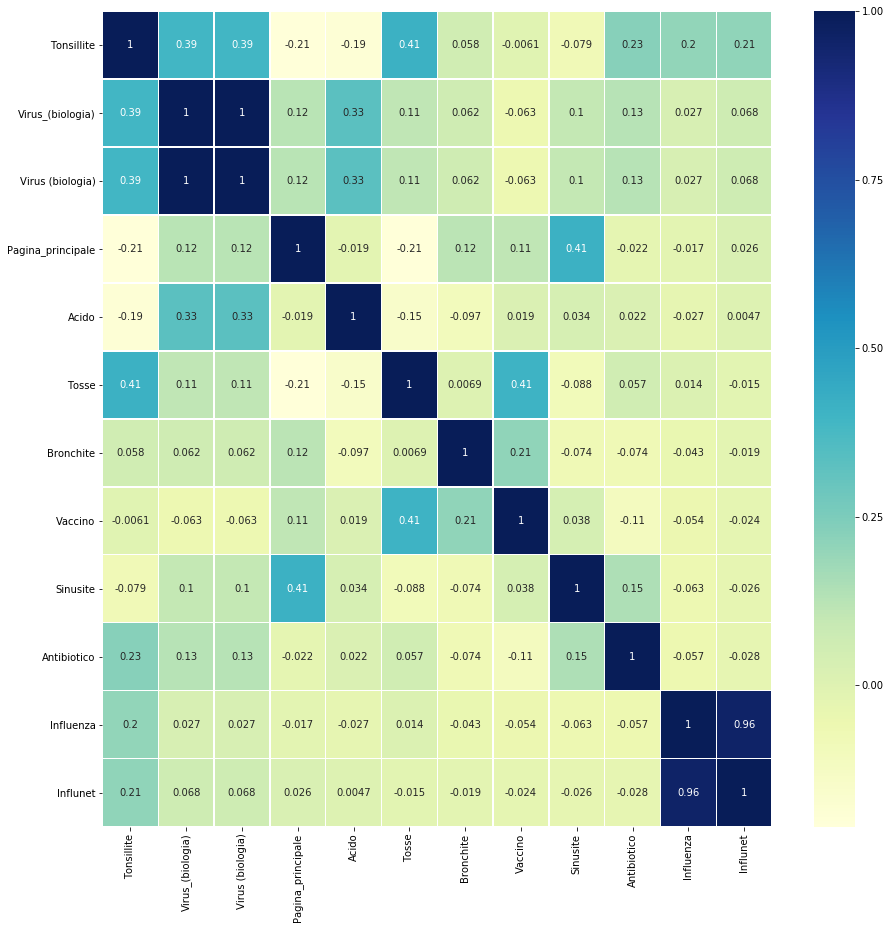

In [134]:
%matplotlib inline

import seaborn as sns
from sklearn import preprocessing

cols = r_df.columns
scaler = preprocessing.StandardScaler()
all_data = scaler.fit_transform(r_df)
all_data = pd.DataFrame(all_data, columns=cols)

corr = all_data.corr()

plt.rcParams['figure.figsize'] = 15, 15
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,  linewidths=.5, cmap='YlGnBu', annot=True)


** By above graph we can observe that Influnet data is most correlated with page **Tonnsillite** after its correlation with Influenza dataset **


# PART 3

## 3.1 - Build a regression model that predicts the Influnet incidence for a given week based on the Wikipedia pageview data for the same week.

We made use of python library sklearn to split our data set in to train and test data sets.

We made use to regression methods such as 

**Multiple Linear regression**

**LASSO**(Least absolute shrinkage and selection operator).Lasso regression dynamically and automatically selects predictor variables for inclusion or exclusion by penalizing the absolute size of the regression coefficients toward zero, thereby selecting a subset of predictor variables which best describe the outcome data

**Using Multiple linear regression**

Mean squared error: 0.1722
Variance score: 0.8994


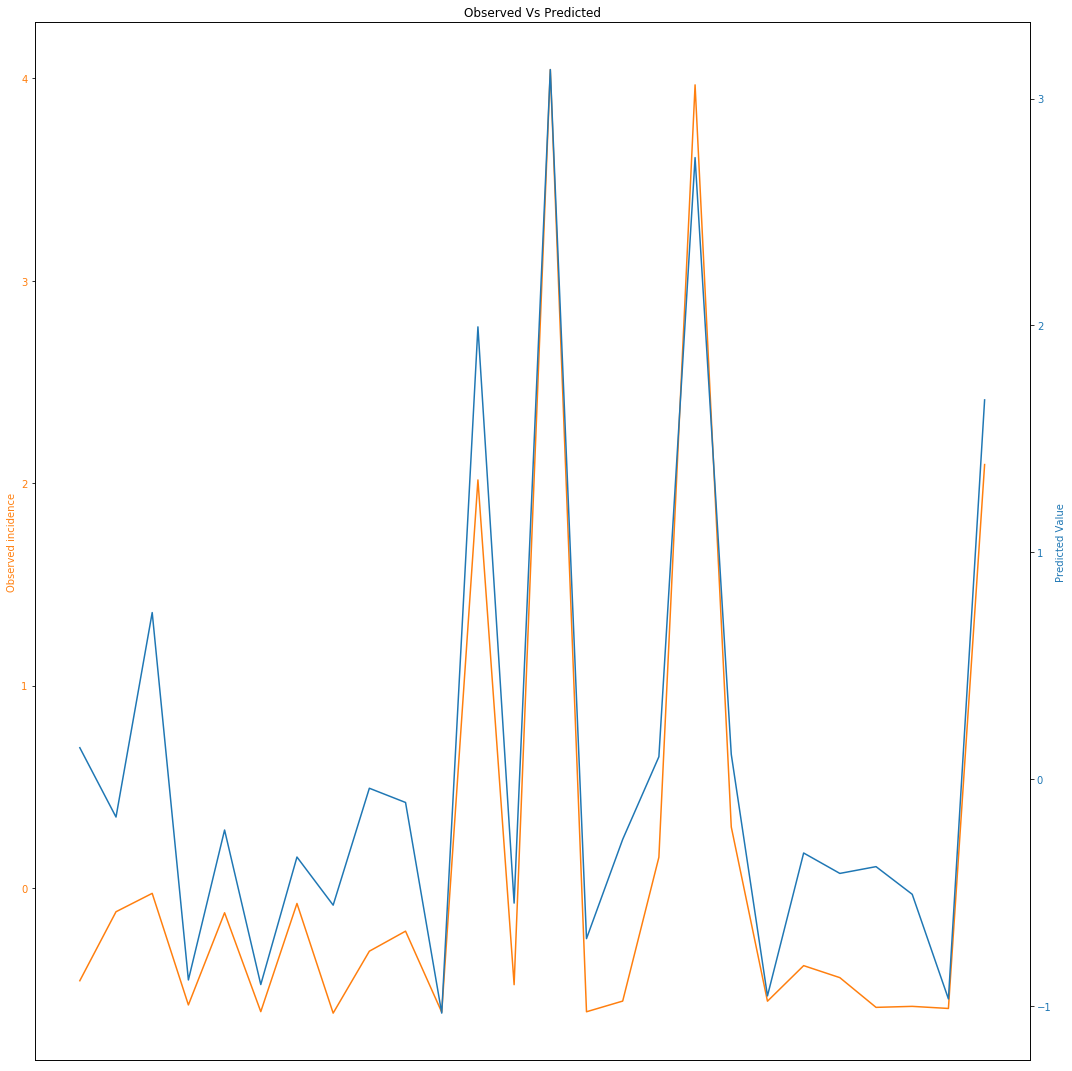

In [152]:
data = r_df[cols_meta[1]]
target = r_df[["Influnet"]]

X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True, test_size=0.3, random_state=49)
#train_test_split external function to distinguish

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

print("Mean squared error: %.4f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.4f' % r2_score(y_test, y_pred))

figure(figsize=(1,5))
fig, ax1 = plt.subplots()
x = np.arange(len(y_test))

color = 'tab:orange'
ax1.set_ylabel('Observed incidence', color=color)
ax1.plot(x, y_test, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predicted Value', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y_pred, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
title = "Observed Vs Predicted"
plt.title(title)
plt.xticks(())
plt.show()

**Using LASSO:**

/Users/vamsigunturi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error: 0.1499
Variance score: 0.9124


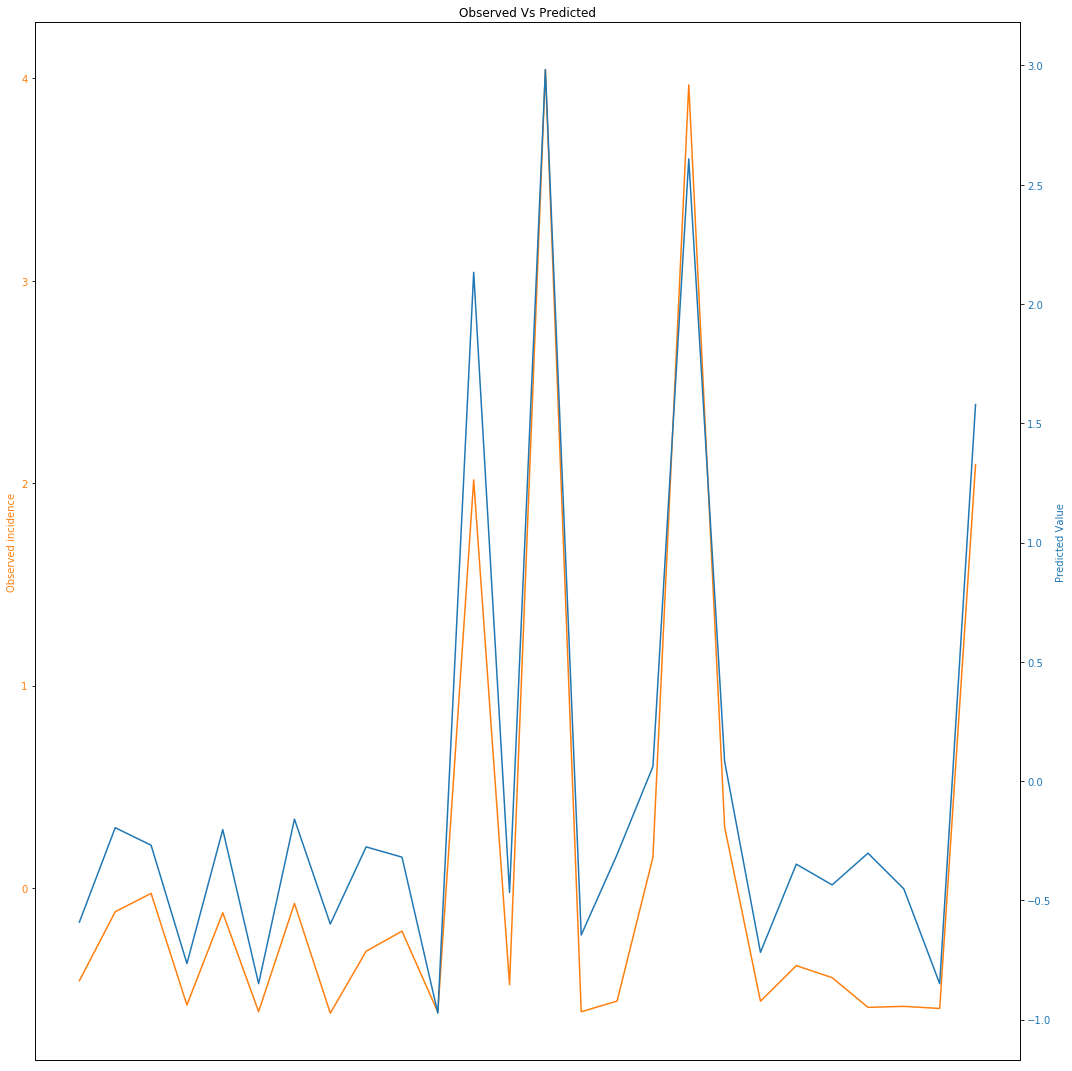

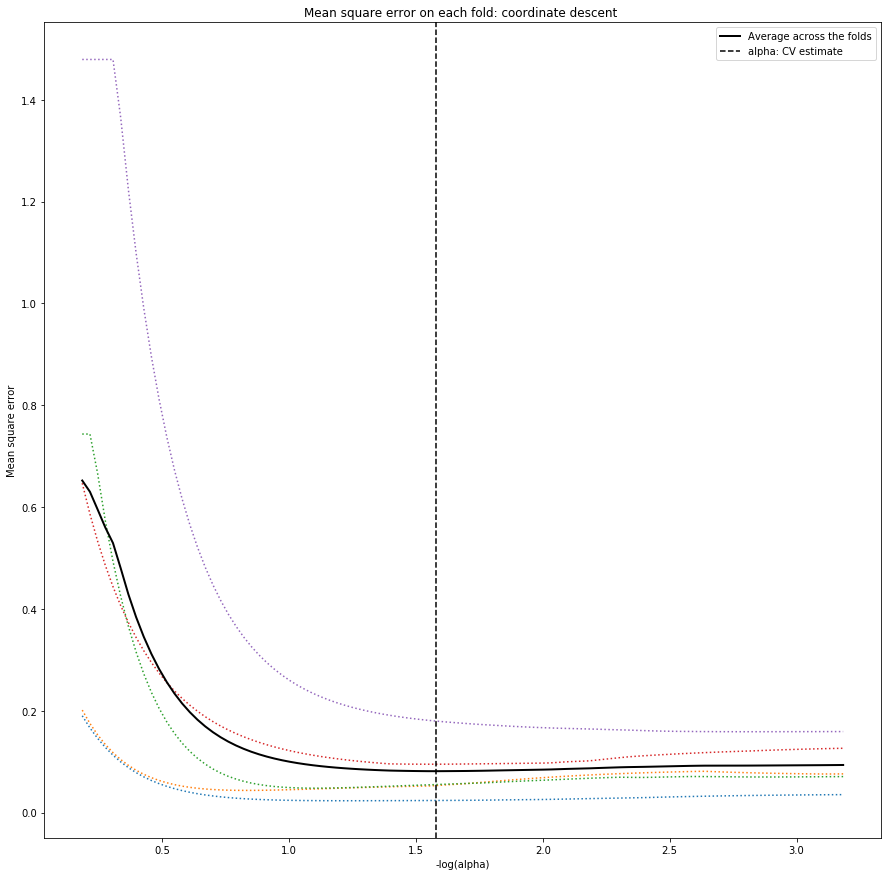

In [145]:
model = LassoCV(cv=5).fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Mean squared error: %.4f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.4f' % r2_score(y_test, y_pred))

fig, ax1 = plt.subplots()
x = np.arange(len(y_test))

color = 'tab:orange'
ax1.set_ylabel('Observed incidence', color=color)
ax1.plot(x, y_test, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # 

color = 'tab:blue'
ax2.set_ylabel('Predicted Value', color=color) 
ax2.plot(x, y_pred, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
title = "Observed Vs Predicted"
plt.title(title)
plt.xticks(())
plt.show()

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k', label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k', label='alpha: CV estimate')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
plt.show()

**As we can see above, LASSO gave the least mean square error of 0.06 when compared to multiple linear regression**

# 3.2 -  Add new features to your model to include data from the preceding week 

### Retrain the model with multiple linear regression and Lasso

**Introduce new features to the data set using dataframe shift operation**

In [153]:
regress_df = pd.read_csv("regression_analysis.csv")

new_cols = []

for c in cols_meta[0]:
    cur_col = c + ' Prev'
    regress_df[cur_col] = regress_df[c].shift()
    new_cols.append(cur_col)
    
regress_df = regress_df.iloc[1:]

**Using linear regression:**

Mean squared error: 0.4930
Variance score: 0.5042


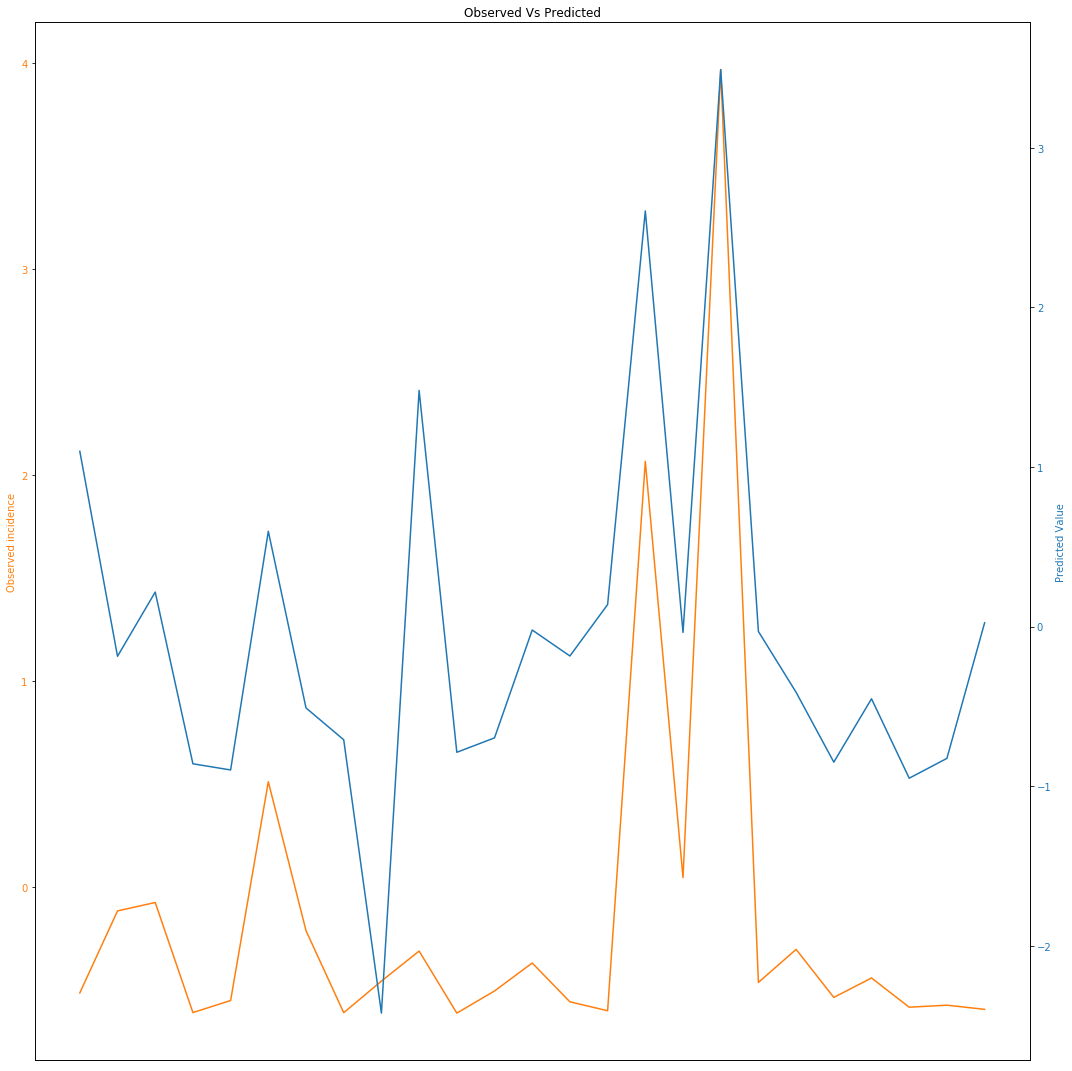

In [154]:
cols_all = cols_meta[1] + new_cols


data = regress_df[cols_all]
target = regress_df[["Influnet"]]

X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True,
                                                    test_size=0.3, random_state=49)

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

print("Mean squared error: %.4f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.4f' % r2_score(y_test, y_pred))

fig, ax1 = plt.subplots()
x = np.arange(len(y_test))

color = 'tab:orange'
ax1.set_ylabel('Observed incidence', color=color)
ax1.plot(x, y_test, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predicted Value', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y_pred, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
title = "Observed Vs Predicted"
plt.title(title)
plt.xticks(())
plt.show()

**Using LASSO:**

/Users/vamsigunturi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error: 0.0590
Variance score: 0.9407


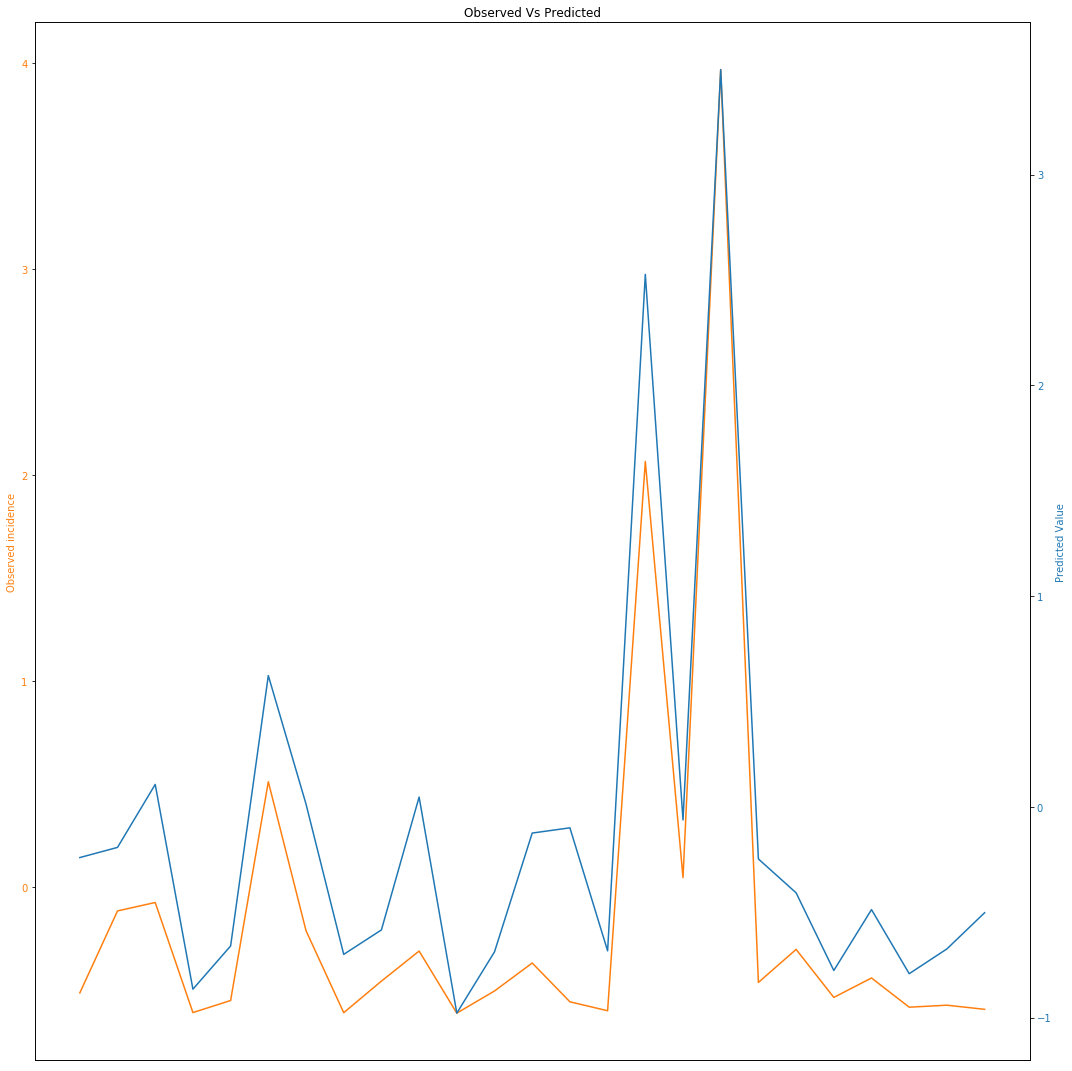

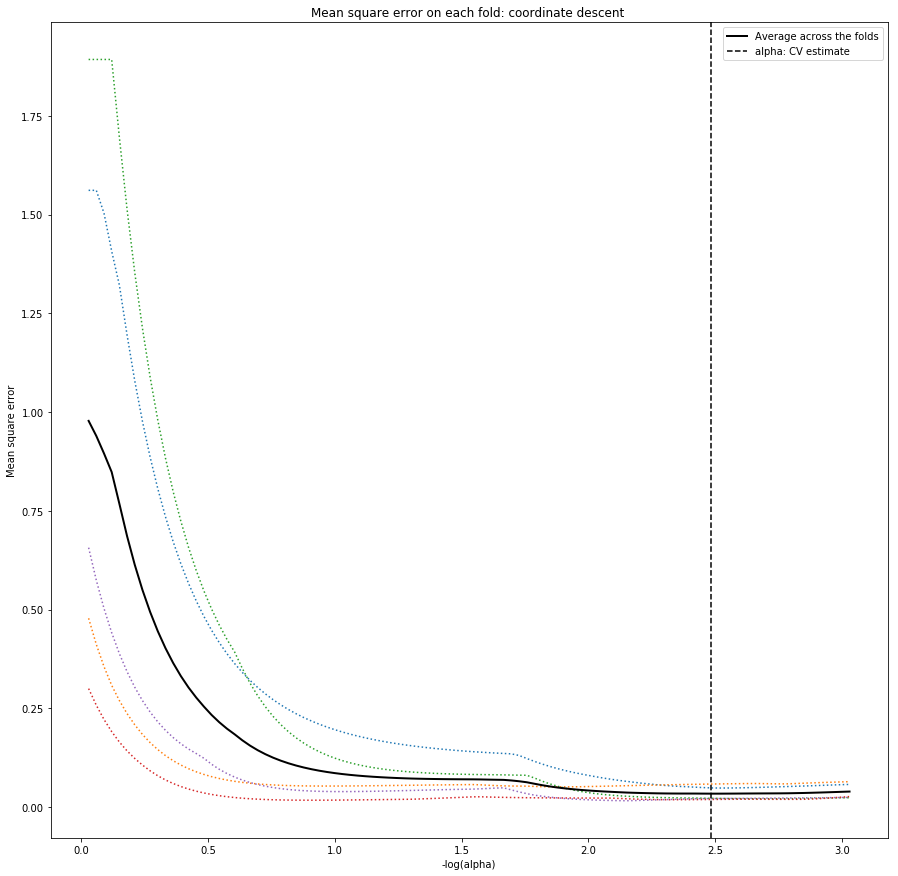

In [158]:
model = LassoCV(cv=5).fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

print("Mean squared error: %.4f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.4f' % r2_score(y_test, y_pred))

fig, ax1 = plt.subplots()
x = np.arange(len(y_test))

color = 'tab:orange'
ax1.set_ylabel('Observed incidence', color=color)
ax1.plot(x, y_test, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predicted Value', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y_pred, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
title = "Observed Vs Predicted"
plt.title(title)
plt.xticks(())
plt.show()

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k', label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k', label='alpha: CV estimate')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
plt.show()

## Conclusion <a name="4"></a>

**Below are the results we obtained,**

**3.1** - 

**Multiple linear regression** -

Mean squared error: **0.1722**

Variance score: **0.8994**

**LASSO** - 

Mean squared error: **0.1499**

Variance score: **0.9124**

**3.2** - 

**Multiple linear regression** - 

Mean squared error: **0.4930**

Variance score: **0.5042**

**LASSO** - 

Mean squared error: **0.0590**

Variance score: **0.9407**


As we can observe, with the actual dataset both the regression model performed comparitively well with LASSO having the best performance. With new features (pertaining to preceeding weeks data) added the performance of the multiple linear regression model decreased multiflold where as the performance of the LASSO model remained the same irrepective of the new features. so we conclude our regression analysis that, for good prediction performance of the Influnet prevalence LASSO is a good choice.
    
    


## Summary <a name="5"></a>

To summarise the work we did on this particular subject,
We initially started with going through the research article shared containing a similar research done for United states which is **D.J. McIver & J. S. Brownstein (2014), "Wikipedia Usage Estimates Prevalence of Influenza-Like Illness in the United States in Near Real-Time"**

After going through this article, we got enough idea on the problem statement at hand and differnt menthods used for statistical analysis such as Jack knife resampling for removing the overfitting, split sample analysis for testing reliability of a model, Pregibons goodness of fit to test the accuracy of different models. Unfortunately we weren't able to incorporate these techniques in our work due to time constraints but we got good idea on bechmarks for statistical analysis. 

We initially tried to automate the wiki view download(gz files) from https://dumps.wikimedia.org/other/pageviews/
through python(We included the code that we used in a separate Jupyter notebook with name **Wiki raw data download notebook**, just so that we documented all our work and effort and for ease of code sepearation likewise) but after sometime we realised that it is time consuming activity and a blocker for the statistical analysis that we planned to make. so we decided to go with pageviewsapi exposed by Wikipedia.

For data collection we mainly relied on pageviewsapi python module. We extracted the influnet information for the period between 10/2015 to 04/2018. Overall we got the data for **84** weeks. We combined both influenza and influnet data sets for ease of comparison and correlation. We applied pearson correlation method and observed that Influnet and Influenza data are highly correlated with coefficient value  **0.9583** 

Then we selected the related wikipedia pages to Influenza manually from the statistics that we observed from multiple resources like https://tools.wmflabs.org/ for instance, we decided on an array for pages and extracted the page views data for 10/2015 to 04/2018(as per the influnet data available). We made use of data from around **30** Influenza related wikipedia pages such as 'sinusite', 'arnica', 'tonsillite', 'influenza spagnola', 'diarrea', 'paracetamolo', 'virus_(biologia)', 'polmonite', 'acido', 'mercurio_(elemento_chimico)', 'malattia', 'epatopatia', 'enfisema', 'morbillo', 'difterite', 'asma', 'bronchite', 'vomito', 'febbre', 'omeopatia', 'vaccino', 'aspirina', 'cefalea', 'pagina_principale', 'raffreddore', 'virus', 'miele', 'inverno', 'tosse', 'virus (biologia)', 'antibiotico' to proceed with our analysis. 

Based on the correlation we performed with these pages with both influenza and influnet data we picked **10** pages such as 'tonsillite', 'virus_(biologia)', 'virus (biologia)', 'pagina_principale', 'acido', 'tosse', 'bronchite', 'vaccino', 'sinusite', 'antibiotico' which are highly correlated with Influnet data. 

Then we created a data set with all these features and performed regression analysis using 2 techniques namely multiple linear regression and LASSO. Based on the results we noted, we observed that LASSO model has a better performance for predicting influnet prevalence with  $R^2$ value of **0.9407**
